# Pytorch classifier notebook

V1 : only 1 split. First implementation  
All folds V1 : with all folds  
All folds V2 : add activation stats plot  
All folds V2.1 : back to  best MLP found so far, and backport fix of activation layers stats. Add weight decay and scheduler (fit one cycle) code

All folds autoencoder MLP V1  
All folds autoencoder MLP V2 : with weights and biases  
All folds autoencoder MLP V3 : replace MLP with xgboost

In [326]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
import torch_optimizer as optim  # Custom optimizers (not officially pytorch) : to use RAdam https://pypi.org/project/torch-optimizer/#radam
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.utils.tensorboard import SummaryWriter
import io
import PIL.Image

import datetime

import faiss

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

DATASET_INPUT_FILE = 'train.csv'

#FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)] + ['cross_41_42_43', 'cross_1_2']
FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)]

# For custom non-overlaped folds generation
TRAIN_PERCENT = 0.70  
TEST_PERCENT = 0.30

# If subsplit of training set : percentage of second training set  
TRAIN1_PERCENT = 0.20  

ACT_N = False  # Add N previous predictions to input of MLP <= Does not work, logic is not right
ACT_N_SIZE = 5

CLUSTERING = False

pd.set_option('display.max_rows', 500)

In [147]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [148]:
# Deterministic Behavior
seed = 42
#os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
#random.seed(seed)
# CuDA Determinism
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [149]:
DO_SWEEP = True
DO_SINGLE_TRAIN = False
#BATCH_SIZE = 50000
#BATCH_SIZE = 4096 # Gave once better results than 50000
#BATCH_SIZE = 2048

#BATCH_SIZE = 300000

#BATCH_SIZE = 4096
#BATCH_SIZE = 8192
#BATCH_SIZE = 32768
BATCH_SIZE = 8192
WEIGHT_DECAY = 1e-4 # Remettre à 1e-5
LEARNING_RATE = 1e-4
DROPOUT = 0.7

EARLY_STOPPING = True

NUM_EPOCHS = 1000
#NUM_EPOCHS = 36

MODEL_FILE = f'model_NN_allfolds_V1.pt'

BATCH_SIZE_AE = 40960
NUM_EPOCHS_AE = 1000
LEARNING_RATE_AE = 1e-3
WEIGHT_DECAY_AE = 1e-4
MODEL_FILE_AE = f'model_NN_AE_allfolds_V1.pt'

RETRAIN_MODEl_AE = False

MODEL_COMMENT_AE = f'All folds MLP autoenc, 2 layers 64 32, good model reloaded, batch size {BATCH_SIZE_AE}, lr={LEARNING_RATE_AE}, patience 5, standard scale, weight decay {WEIGHT_DECAY_AE}, dropout 0.5, with cross features, no scheduler, no std scale'
MODEL_COMMENT = f'All folds MLP with autoenc (noise 0.01)), 3 layers 130, 200 and 100, good model reloaded, batch size {BATCH_SIZE}, lr={LEARNING_RATE}, patience 5, standard scale, weight decay {WEIGHT_DECAY}, 0.7 dropout, without cross features, no scheduler, no std scale'

In [150]:
'''
sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'values': [524288, 262144, 131072, 65536, 32768, 16384, 8192, 4096, 2048, 1024, 512]
        },
        'dropout': {
            'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        },
        'learning_rate': {
            #'values': [1e-2, 1e-3, 1e-4, 3e-4, 1e-5]
            #'values': [1e-2, 1e-3, 1e-4]
            'values': [1e-2, 1e-3]
        },

        'weight_decay': {
            'values': [1e-2, 1e-3, 1e-4, 1e-5]
        },
    
        'use_autoenc': {
            'values': ['encoder-decoder', 'encoder', 'encoder-only', 'None']
            #'values': ['encoder-decoder', 'None']
        },
        
        'activation_function': {
            'values': ['relu', 'leakyrelu']
        },
        
    }
}
'''

sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'min': 4096,
            'max': 65536,
            'distribution': 'int_uniform',
        },
        'dropout': {
            'min': 0.3,
            'max': 0.5,
            'distribution': 'uniform',
        },
        'learning_rate': {
            'min': 0.0005,
            'max': 0.002,
            'distribution': 'uniform',
        },

        'weight_decay': {
            'min': 0.00001,
            'max': 0.0002,
            'distribution': 'uniform',

        },
    
        'use_autoenc': {
            'values': ['encoder', 'encoder-only']
            #'values': ['encoder-decoder', 'None']
        },
        
        'activation_function': {
            'values': ['leakyrelu']
        },
        
    }
}

In [9]:
import wandb

wandb.login()

wandb: Currently logged in as: fboyer (use `wandb login --relogin` to force relogin)


True

In [151]:
def pyStandardScale(tensor, mean, std):
    return((tensor - mean) / std)

In [152]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

from matplotlib.colors import ListedColormap
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv_indices_custom(cv_custom, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_custom):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [153]:
# This function accounts for variable instance counts in each split by dividing utility_pi by number of instances (but this has been removed)
# It also does some copy of dataframe to prevent memory overwrite
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]

    if (np.sqrt(df_test_utility_pi.pow(2).sum()) == 0):
        t = 0

    else:
        t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))

    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [154]:
from bisect import bisect_left

# The aim of this function is to return closest date from an index
# So that split indices correspond to start or end of a new day
# myList contains list of instances that correspond to start of a new da

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [155]:
class SaveOutputActivationStats:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        #self.outputs.append(module_out)
        #print('Save output callback :')
        #print(module)
        #print({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        self.outputs.append({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        
    def clear(self):
        self.outputs = []

In [156]:
#fig, ax = plt.subplots(1, 1)
#
#plot_cv_indices(cv, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20);

In [157]:
torch.device

torch.device

In [158]:
torch.cuda.is_available()

True

In [159]:
torch.cuda.current_device()

0

In [160]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

# Load data

In [161]:
# Load data
    
df = pd.read_csv(DATASET_INPUT_FILE)
df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

print('Data loaded')


Data loaded


# Feature engineering

In [162]:
#df['cross_41_42_43'] = df['feature_41'] + df['feature_42'] + df['feature_43']

In [163]:
#df['cross_1_2'] = df['feature_1'] / (df['feature_2'] + 1e-5)

# Non overlap fold generation

In [164]:
date_indexes_list = df.groupby('date')['ts_id'].first().to_list()

In [165]:
base_train_split_size = int((df.shape[0] // 5) * TRAIN_PERCENT)

In [166]:
base_test_split_size = int((df.shape[0] // 5) * TEST_PERCENT)

In [167]:
train_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [168]:
#test_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [169]:
train_split_start_indexes

[0, 477711, 958233, 1435933, 1913985]

In [170]:
df.shape[0] - 1

2390490

In [171]:
# We'll have 5 folds of 3 subsets each (2 training sets and 1 test set per fold)
# (1st training set of each fold will be used for 1st model, ie auto encoder)

NB_FOLDS = 5
last_index = df.shape[0] - 1

cv_table = []

for fold_indice in range(NB_FOLDS):
    fold_train_start_index = train_split_start_indexes[fold_indice]
    
    if (fold_indice == NB_FOLDS - 1):    
        nextfold_train_start_index = last_index
        
    else:
        nextfold_train_start_index = train_split_start_indexes[fold_indice + 1]
    
    fold_test_start_index = take_closest(date_indexes_list, int(TRAIN_PERCENT * (nextfold_train_start_index - fold_train_start_index) + fold_train_start_index  ))
    fold_train2_start_index = take_closest(date_indexes_list, int(TRAIN1_PERCENT * (fold_test_start_index - fold_train_start_index) + fold_train_start_index  ))
    
    cv_table.append(fold_train_start_index)
    cv_table.append(fold_train2_start_index)
    cv_table.append(fold_test_start_index)

In [172]:
cv_table.append(last_index)

In [173]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [174]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [175]:
NB_FOLDS

5

In [176]:
cv_tuples = []

for i in range(0, NB_FOLDS*3, 3):
    cv_tuples.append([df.loc[cv_table[i]:cv_table[i+1]-1, :].index.to_list(), df.loc[cv_table[i+1]:cv_table[i+2]-1, :].index.to_list(),
                      df.loc[cv_table[i+2]:cv_table[i+3]-1, :].index.to_list()])

In [177]:
len(cv_tuples[0][2])

141102

In [178]:
cv_tuples_generator = iter(cv_tuples)

In [179]:
#fig, ax = plt.subplots(1, 1)

#plot_cv_indices_custom(cv_tuples_generator, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20); 

#cv_tuples_generator = iter(cv_tuples)

In [180]:
# Size of training set :
#train_sets_table =  [cv_tuples[i][0] for i in range(5)]
#sum([len(train_set_table) for train_set_table in train_sets_table])

In [181]:
# Our old time series split (with overlap : required 1 neural network trained per split)
# But in this script it's not needed because we're training 1 unique network, with a different fold strategy (non overlaped)
#cv = PurgedGroupTimeSeriesSplit(
#    n_splits=5,
#    max_train_group_size=180,
#    group_gap=20,
#    max_test_group_size=60
#)

In [182]:
#train_index, test_index = next(cv.split(df, (df['resp'] > 0)*1, df['date']))

In [183]:
#(df.loc[train_index, 'resp'] > 0).astype(np.byte)

In [184]:
f_mean = df.loc[:, FEATURES_LIST_TOTRAIN].mean(axis=0)

In [185]:
f_mean.shape

(130,)

In [186]:
df.fillna(f_mean, inplace=True)

In [187]:
#print('Sum of model parameters:')
#[print(p.sum()) for p in model.parameters()]

In [188]:
#writer = SummaryWriter()

#writer.add_text('test', 'test:'  + str(model).replace('\n', '<BR>'))

#writer.flush()
#writer.close()

In [189]:
#str([p.numel() for p in model.parameters()])

In [190]:
folds_list = []

for fold, (train1_index, train2_index, test_index) in enumerate(cv_tuples_generator):
    folds_list.append((train1_index, train2_index, test_index))

In [191]:
folds_list_train1 = [folds_list[i][0] for i in range(5)]
folds_list_train1_flat = [folds_list_train1_item for sublist in folds_list_train1 for folds_list_train1_item in sublist]
folds_list_train1_unique = list(set(folds_list_train1_flat))

folds_list_train2 = [folds_list[i][1] for i in range(5)]
folds_list_train2_flat = [folds_list_train2_item for sublist in folds_list_train2 for folds_list_train2_item in sublist]
folds_list_train2_unique = list(set(folds_list_train2_flat))

In [192]:
len(folds_list_train1_unique)

337464

In [193]:
len(folds_list_train2_unique)

1339691

In [194]:
np.sum([len(folds_list_train1_item) for folds_list_train1_item in folds_list_train1])

337464

In [195]:
np.sum([len(folds_list_train2_item) for folds_list_train2_item in folds_list_train2])

1339691

In [196]:
len(folds_list_train1_flat)

337464

In [197]:
folds_list_test = [folds_list[i][2] for i in range(5)]
folds_list_test_flat = [folds_list_test_item for sublist in folds_list_test for folds_list_test_item in sublist]
folds_list_test_unique = set(folds_list_test_flat)

In [198]:
np.sum([len(folds_list_test_item) for folds_list_test_item in folds_list_test])

713335

In [199]:
len(folds_list_test_flat)

713335

In [200]:
len(folds_list_train1_flat) + len(folds_list_train2_flat) + len(folds_list_test_flat)

2390490

In [201]:
df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN].to_numpy().shape

(141980, 130)

In [202]:
df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy().mean(axis=0)

array([ 0.00880718,  0.39574469,  0.33059838,  0.00919269,  0.00341737,
       -0.00498373, -0.01455459,  0.05534631,  0.02511896,  0.2646538 ,
        0.16705702,  0.09489698,  0.04450428,  0.15251293,  0.07996651,
        0.22166532,  0.12827658,  0.12181565,  0.10958852,  0.29772963,
        0.26463247,  0.1881408 ,  0.17251055,  0.25474009,  0.23267903,
        0.29794049,  0.2685417 ,  0.13985131,  0.16285107,  0.33060734,
        0.34385913,  0.22684687,  0.25190658,  0.31637359,  0.3359838 ,
        0.35284181,  0.36773315,  0.02650339,  0.0186391 ,  0.04320553,
        0.05298663,  0.45417433,  0.37762691,  0.41617323,  0.43927675,
        0.48651095,  0.49207956,  0.36839975,  0.50144387,  0.54379067,
        0.53074971,  0.45673965,  0.05646874,  0.38900233,  0.37690587,
        0.77549302,  0.92466193,  0.78590429,  0.80847667,  0.89895923,
        0.55335406,  0.55554392,  0.55922873,  0.56139559,  0.44231975,
        0.61884351,  0.61715568,  0.59770334,  0.59814018,  0.37

In [203]:
len(list(set(folds_list_train1_unique + folds_list_train2_unique)))

1677155

In [204]:
torch.mean(torch.tensor(df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy(), device='cpu'), axis=0)

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [205]:
torch.tensor(f_mean)

tensor([ 9.8386e-03,  3.8558e-01,  3.5769e-01,  8.9192e-03,  4.1501e-03,
        -3.7146e-03, -1.2589e-02,  5.1777e-02,  2.6828e-02,  2.4881e-01,
         1.8235e-01,  8.9122e-02,  4.9486e-02,  1.4311e-01,  8.9027e-02,
         2.1168e-01,  1.4630e-01,  1.2122e-01,  1.1358e-01,  2.9381e-01,
         2.6877e-01,  1.8691e-01,  1.7698e-01,  2.5244e-01,  2.3856e-01,
         2.9407e-01,  2.7318e-01,  1.3548e-01,  1.6088e-01,  3.2189e-01,
         3.4253e-01,  2.2056e-01,  2.5013e-01,  3.0822e-01,  3.3535e-01,
         3.4145e-01,  3.6583e-01,  2.9320e-02,  2.2892e-02,  4.0022e-02,
         5.0750e-02,  4.4505e-01,  3.6018e-01,  3.4603e-01,  4.1153e-01,
         4.3803e-01,  4.7612e-01,  3.4787e-01,  4.9963e-01,  5.6400e-01,
         5.1226e-01,  4.5739e-01,  4.5744e-02,  3.6270e-01,  3.5887e-01,
         6.5260e-01,  8.0495e-01,  6.6135e-01,  6.7981e-01,  7.6259e-01,
         5.5640e-01,  5.5817e-01,  5.4554e-01,  5.4678e-01,  4.3506e-01,
         6.0757e-01,  6.0850e-01,  5.9519e-01,  5.9

# Training KMeans clusterer

In [63]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]



In [64]:
df_forclustering = df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})

In [65]:
df_forclustering = np.copy(df_forclustering[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [66]:
NB_CLUSTERS = 5

clusterer = FaissKMeans(n_clusters=NB_CLUSTERS, n_init=10, max_iter=3000)
clusterer.fit(df_forclustering)

In [67]:
df_full = df.loc[:, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})
df_full = np.copy(df_full[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [68]:
y_clusters = clusterer.predict(df_full)

In [69]:
df['cluster'] = y_clusters + 1  # +1 to avoid cluster indice 0 (less practical for gradients)

In [109]:
if (CLUSTERING == True):
    FEATURES_LIST_TOTRAIN = FEATURES_LIST_TOTRAIN + ['cluster']

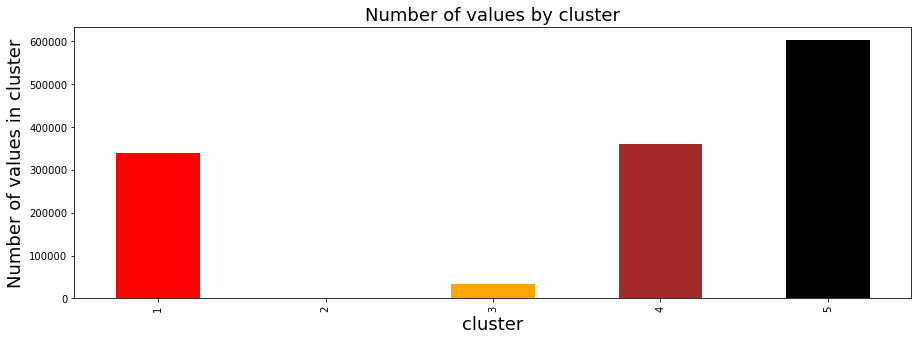

In [71]:
colors = ['red', 'blue', 'orange', 'brown', 'black']

fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Number of values in cluster', fontsize=18)
ax.set_title('Number of values by cluster', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].count().plot.bar(figsize=(15,5), ax=ax, color=colors);

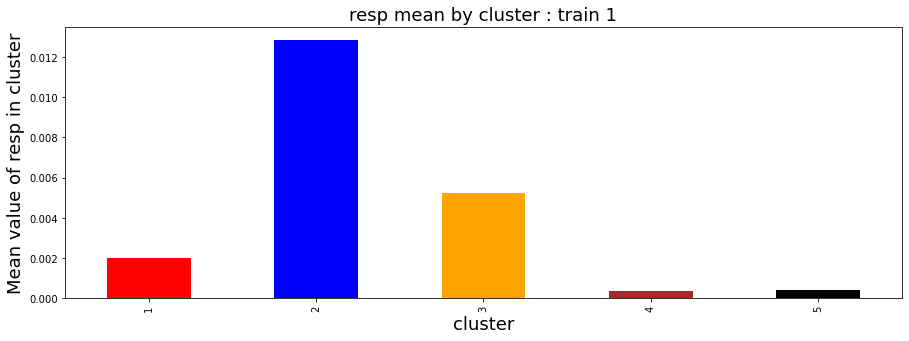

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 1', fontsize=18)

df.loc[folds_list_train1_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

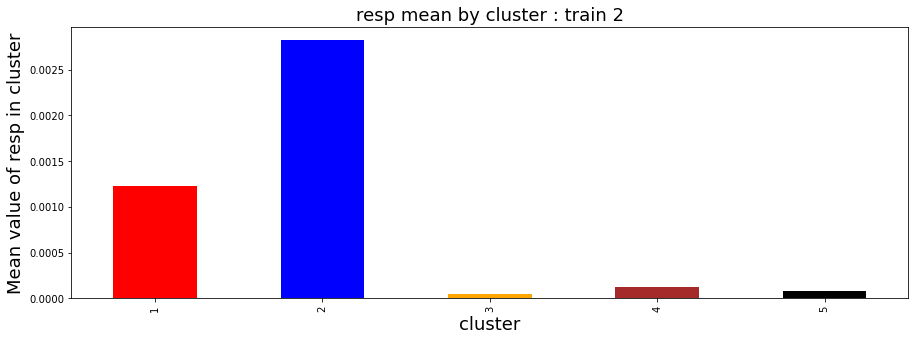

In [73]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 2', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

# Training XGB model

## Training XGB model that predicts resp n-1

In [69]:
class XGBClassifier_wrapper(BaseEstimator, ClassifierMixin):  
    ''' Params passed as dictionnary to __init__, for example :
        params_space = {
       'features': FEATURES_LIST_TOTRAIN, 
        'random_state': 42,
        'max_depth': 12,
        'n_estimators': 500,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.3,
        'tree_method': 'gpu_hist'
        }
    '''
    def __init__(self, params):
        self.fitted = False
        
        self.features = list(params['features'])
        self.random_state = params['random_state']
        self.max_depth = params['max_depth']
        self.n_estimators = params['n_estimators']
        self.learning_rate = params['learning_rate']
        self.subsample = params['subsample']
        self.colsample_bytree = params['colsample_bytree']
        self.gamma = params['gamma']
        self.tree_method = params['tree_method']  
        
        #print('Features assigned :')
        #print(self.features)

        self.model_internal = XGBClassifier(
            random_state= self.random_state,
            max_depth= self.max_depth,
            n_estimators= self.n_estimators,
            learning_rate= self.learning_rate,
            subsample= self.subsample,
            colsample_bytree= self.colsample_bytree,
            tree_method= self.tree_method,
            gamma = self.gamma,
            #objective= 'binary:logistic',
            #disable_default_eval_metric=True,
            )

    def fit(self, X, y=None):
        print('Model used for fitting:')
        print(self.model_internal)
        self.model_internal.fit(X[self.features], y)
        
        self.fitted = True
        return self

    def predict(self, X, y=None):
        if (self.fitted == True):
            print('predict called')
            return(self.model_internal.predict(X[self.features]))
        
        else:
            print('You must fit model first')
            return(None)

    def predict_proba(self, X, y=None):
        if (self.fitted == True):
            print('predict proba called')
            return(self.model_internal.predict_proba(X[self.features]))
        
        else:
            print('You must fit model first')
            return(None)
        

    #def set_params(self, **parameters):
    #    for parameter, value in parameters.items():
    #        setattr(self, parameter, value)

        
    def score(self, X, y=None):        
        print('Type of X:')
        print(type(X))
        
        print('Shape of X:')
        print(X.shape)
        
        print('Type of y:')
        print(type(y))
        
        print('model fitted ?')
        print(self.fitted) # Usually returns yes at this point when called by cross_val_score
        
        if y is None:
            print('y is None')
            y_preds = pd.Series(self.model_internal.predict(X.reset_index(drop=True)[self.features]))
            
        else: # cross_val_score goes there
            print('y is not None')
            y_preds = pd.Series(y)
        
        return(utility_function(X.reset_index(drop=True), y_preds)) 
    
    def accuracy_score(self, X, y=None):
        if y is None:
            print('y is None in accuracy_score method : pass predictions as y to avoid launching predict')
            y_preds = pd.Series(self.model_internal.predict(X.reset_index(drop=True)[self.features]))
            
        else: # cross_val_score goes there
            #print('y is not None')
            y_preds = pd.Series(y)
            
        return(accuracy_score(X['resp_positive'], y_preds))

In [81]:
# Calculate label of current step
y_train1_resp_positive = (df.loc[folds_list_train1_unique, 'resp'] > 0).astype(np.byte)

# Shift values of resp to get resp of step n-1
y_train1_resp_n1_positive = y_train1_resp_positive.shift(1, fill_value=0)


model_n1 = XGBClassifier(
    random_state= 42,
    max_depth= 12,
    n_estimators= 500,
    learning_rate= 0.01,
    subsample= 0.9,
    colsample_bytree= 0.2,
    #tree_method= 'gpu_hist',
    gamma = None,
    )

model_n1.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], y_train1_resp_n1_positive, verbose=True)

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=24, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Train xgb main model

In [97]:
model_wrapped = XGBClassifier_wrapper({
   'features': ['feature_'+str(i) for i in range(130)] + ['resp_n1_predict'], 
    'random_state': 42,
    'max_depth': 10,
    'n_estimators': 500,
    'learning_rate': 0.02,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'gamma': None,
    'tree_method': 'gpu_hist'        
    })

In [98]:
train2_predictions_resp_n1 = model_n1.predict(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN])
df.loc[folds_list_train2_unique, 'resp_n1_predict'] = pd.DataFrame(train2_predictions_resp_n1, index=folds_list_train2_unique, columns=['resp_n1_predict'])
        
model_wrapped.fit(df.loc[folds_list_train2_unique], (df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte))

Model used for fitting:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier_wrapper(params=None)

In [99]:
precision_n1 = precision_score((df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte).shift(1, fill_value=0), df.loc[folds_list_train2_unique, 'resp_n1_predict'])
recall_n1 = recall_score((df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte).shift(1, fill_value=0), df.loc[folds_list_train2_unique, 'resp_n1_predict'])

print(f'Precision/Recall of resp n-1')
print(f'Precision score for resp n-1: {precision_n1}')
print(f'Recall score for resp n-1: {recall_n1}')

Precision/Recall of resp n-1
Precision score for resp n-1: 0.5051726105497034
Recall score for resp n-1: 0.641329495577563


In [100]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS): 
    df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN]

    test_predictions_resp_n1 = model_n1.predict(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN])
    df.loc[folds_list_test[fold_indice], 'resp_n1_predict'] = pd.DataFrame(test_predictions_resp_n1, index=folds_list_test[fold_indice], columns=['resp_n1_predict'])
    test_predictions = model_wrapped.predict(df.loc[folds_list_test[fold_indice]])

    scores.append(model_wrapped.score(df.loc[folds_list_test[fold_indice]], test_predictions))
    accuracy_scores.append(model_wrapped.accuracy_score(df.loc[folds_list_test[fold_indice]], test_predictions))  

    df_featimportance = pd.DataFrame(model_wrapped.model_internal.feature_importances_, index=df[model_wrapped.features].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    print(f'Feature importances for split {fold_indice}:')
    print(df_featimportance_cumulated)

print({'utility_score': sum(scores), 'utility_scores': scores, 'utility_score_std': np.std(scores), 'accuracy_scores': accuracy_scores})

predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(141102, 141)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
Feature importances for split 12:
                 Importance  % feat importance cumulé
feature_45         0.014291                  0.014291
feature_42         0.014124                  0.028416
feature_43         0.014109                  0.042525
feature_41         0.013462                  0.055986
feature_44         0.012669                  0.068655
feature_63         0.012291                  0.080946
feature_39         0.012206                  0.093152
feature_27         0.011925                  0.105077
feature_61         0.011572                  0.116649
feature_6          0.011355                  0.128004
feature_62         0.011309                  0.139313
feature_60         0.011234                  0.150546
feature_5          0.011116                  0.161662
feature_40         0.010649                  0.1723

avec resp n-1 predict :   
{'utility_score': 2220.2233472739963, 'utility_scores': [98.25101783384773, 900.8701790502922, -0.0, 0.4453615853177138, 1220.6567888045388], 'utility_score_std': 514.848559103147, 'accuracy_scores': [0.5193973154172159, 0.5205967005967006, 0.5094644046384852, 0.5159758568293095, 0.5272784899281588]}

sans resp n-1 predict :
{'utility_score': 2210.0027063381485, 'utility_scores': [93.2897168336882, 954.4061873586404, -0.0, 11.77975627326354, 1150.5270458725563], 'utility_score_std': 503.3136189838432, 'accuracy_scores': [0.5196949724312908, 0.5218041418041418, 0.5108306843070078, 0.5164542180201475, 0.5262360895900831]}  

sans resp n-1 predict mais avec cluster en entrée :
{'utility_score': 1843.4582433367275, 'utility_scores': [92.97847070444716, 575.5300947961299, -0.0, 4.662222031689218, 1170.2874558044612], 'utility_score_std': 453.829636002962, 'accuracy_scores': [0.5191350937619594, 0.5202878202878203, 0.5089632065691275, 0.5165034610839102, 0.527764473869559]}    

Avec autoencoder (couche cachée) as input :  
{'utility_score': 1835.9160062792303, 'utility_scores': [56.12364094625926, 620.7855166503907, -0.0, -0.0, 1159.0068486825803], 'utility_score_std': 459.9356215007981, 'accuracy_scores': [0.5207013366217347, 0.5192488592488592, 0.5096497792668777, 0.5098978558163093, 0.5204747147485561]}  

Avec prédiction du bin en input :
{'utility_score': 1984.7216513367114, 'utility_scores': [12.194987258447853, 768.0975152431711, -0.0, 4.648166944291761, 1199.7809818908006], 'utility_score_std': 498.3562007124659, 'accuracy_scores': [0.5184192995138269, 0.519003159003159, 0.5105148608660428, 0.5153216275536046, 0.5257078461755177]}

Avec prédiction du fold en input (sans resp n-1) :
{'utility_score': 1843.4582433367275, 'utility_scores': [92.97847070444716, 575.5300947961299, -0.0, 4.662222031689218, 1170.2874558044612], 'utility_score_std': 453.829636002962, 'accuracy_scores': [0.5191350937619594, 0.5202878202878203, 0.5089632065691275, 0.5165034610839102, 0.527764473869559]}

In [104]:
df.drop(columns=['resp_n1_predict'], inplace=True)

## Train xgb main model without resp n-1

In [115]:
model_wrapped = XGBClassifier_wrapper({
   'features': FEATURES_LIST_TOTRAIN, 
    'random_state': 42,
    'max_depth': 10,
    'n_estimators': 500,
    'learning_rate': 0.02,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'gamma': None,
    'tree_method': 'gpu_hist'        
    })

In [116]:
model_wrapped.fit(df.loc[folds_list_train2_unique], (df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte))

Model used for fitting:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier_wrapper(params=None)

In [117]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS): 
    test_predictions = model_wrapped.predict(df.loc[folds_list_test[fold_indice]])

    scores.append(model_wrapped.score(df.loc[folds_list_test[fold_indice]], test_predictions))
    accuracy_scores.append(model_wrapped.accuracy_score(df.loc[folds_list_test[fold_indice]], test_predictions))  

    df_featimportance = pd.DataFrame(model_wrapped.model_internal.feature_importances_, index=df[model_wrapped.features].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    print(f'Feature importances for split {fold_indice}:')
    print(df_featimportance_cumulated)

print({'utility_score': sum(scores), 'utility_scores': scores, 'utility_score_std': np.std(scores), 'accuracy_scores': accuracy_scores})

predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(141102, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
Feature importances for split 0:
             Importance  % feat importance cumulé
feature_43     0.014191                  0.014191
feature_45     0.014148                  0.028339
feature_42     0.014084                  0.042423
feature_41     0.013654                  0.056077
feature_44     0.012552                  0.068629
feature_39     0.012326                  0.080955
feature_27     0.012271                  0.093226
feature_63     0.012136                  0.105362
feature_61     0.011630                  0.116991
feature_62     0.011258                  0.128249
feature_6      0.011253                  0.139503
feature_5      0.011222                  0.150724
feature_60     0.011064                  0.161788
feature_40     0.010715                  0.172503
feature_3      0.010545                  0.183049
feature_

# Training auto encoder

In [120]:
torch.manual_seed(seed)  

ENCODER_SIZE = 32
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        self.encoder = nn.Sequential(
            #nn.Dropout(0.5),  # Noise layer
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 64),
            nn.ReLU(),
            nn.Linear(64, ENCODER_SIZE),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(             
            nn.Linear(ENCODER_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, len(FEATURES_LIST_TOTRAIN)),
        )
        
    def forward(self,x):
        if self.training:
            x = x + 0.01 * torch.randn(x.shape[0], x.shape[1]).double(). to('cuda')  # 0.01 = noise variance
            
        x = self.encoder(x)
        x = self.decoder(x)
        return x        

model = AutoEncoder().double().to('cuda')
    
#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list
    
if (RETRAIN_MODEl_AE == False):
    model_AE = model
    model_AE.load_state_dict(torch.load(MODEL_FILE_AE,map_location=torch.device('cuda')))
    print('Model AE loaded')

else:    
    print('Training started')
    patience=5

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    today = datetime.datetime.now()
    now_str = today.strftime("%b%d_%H-%M-%S")
    tensorboard_dir_AE = 'runs_AE/' + now_str
    writer = SummaryWriter(log_dir=tensorboard_dir_AE)

    ts_train = torch.tensor(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    #ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train_mean = torch.tensor(f_mean)
    # If you want to use Standard scale : calculate mean from f_mean and std scale from whole dataset
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_AE, shuffle=True)

    ts_test = [None] * 5
    #ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        #ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE_AE)

    loss_fn = nn.MSELoss().to('cuda')
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_AE, weight_decay=WEIGHT_DECAY_AE) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    #model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))

    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 10000
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(NUM_EPOCHS_AE): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs = batch[0].to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = loss_fn(outputs, inputs.double())
                loss.backward()
                optimizer.step()

                if scheduler:
                    scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            fig, ax = plt.subplots(1, 3, figsize=(25, 4))

            ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
            ax[0].set_xlabel('Batch instances')
            ax[0].set_ylabel('Mean')
            ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

            ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
            ax[1].set_xlabel('Batch instances')
            ax[1].set_ylabel('Standard deviation')
            ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

            ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
            ax[2].set_xlabel('Batch instances')
            ax[2].set_ylabel('Percentage')
            ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

            plot_buf = io.BytesIO()
            plt.savefig(plot_buf, format='jpeg')
            plt.close()

            plot_buf.seek(0)
            image = PIL.Image.open(plot_buf)
            image = transforms.ToTensor()(image)
            writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs = batch[0].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, inputs.double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += inputs.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))        

        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)        

        writer.flush()

        # Check if Early Stopping

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_loss == {the_last_loss}')
            torch.save(model.state_dict(), MODEL_FILE_AE)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE_AE)

    writer.add_text(f"Global valid/Loss", f"Best loss: {the_last_loss}", the_best_epoch)

    scores_results = {'Loss': the_last_loss, 'Loss folds': vepoch_loss_folds, 'Loss_std': np.std(vepoch_loss_folds)}

    writer.add_text('Final score', str(scores_results))
    writer.add_text('Batch size', str(BATCH_SIZE_AE))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS_AE))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT_AE)

    writer.close()

    print('Training summary:')
    print(scores_results)

    model_AE = model
    model_AE.eval()
    print('Training ended')

Model AE loaded


In [78]:
df[FEATURES_LIST_TOTRAIN].mean().mean()

0.33611383846199827

In [79]:
1.08 / df[FEATURES_LIST_TOTRAIN].mean().mean()

3.2131970672255052

In [80]:
#ts_train.mean(axis=0)

In [81]:
#loss_fn(ts_train[0:5, :], model_AE(ts_train[0:5, :]))

In [82]:
#model_AE(ts_train[0:5, :])[0, 5]

In [83]:
#ts_train[0, 5]

In [84]:
#loss_fn(ts_train[50, 5], model_AE(ts_train[:, :])[50, 5])

# Training XGB with auto encoder as input

## Train xgb main model without resp n-1

In [158]:
model_wrapped = XGBClassifier_wrapper({
   'features': [i for i in range(0,32)], 
    'random_state': 42,
    'max_depth': 10,
    'n_estimators': 500,
    'learning_rate': 0.02,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'gamma': None,
    'tree_method': 'gpu_hist'        
    })

In [161]:
pd.DataFrame(model_AE.encoder(torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy()).to('cuda')).detach().cpu().numpy()), (df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte).shape

(                0          1          2   ...         29         30         31
 0         4.920520  10.393370   2.848430  ...   6.706162   7.553328   3.229464
 1        13.425105  13.004536  11.671365  ...   9.275853  12.335581  10.960831
 2         6.196855  19.288076  11.200149  ...  14.050742  12.413522  11.058138
 3        14.453975  16.254791  10.539001  ...   6.403368  13.586235  10.107546
 4         2.861047   6.505847   3.192688  ...   5.661924   2.876822   3.475592
 ...            ...        ...        ...  ...        ...        ...        ...
 1339686  13.649236   8.577240  14.118822  ...  16.139911  13.834152   5.142769
 1339687  13.432552   6.213704  15.470038  ...   7.540236  12.079553  11.455648
 1339688  12.401143   9.138115  20.421107  ...   8.705382  18.215061  14.264449
 1339689  12.546768  12.319803  12.883993  ...   7.110584  11.400167   5.871154
 1339690   6.624428   8.917270   8.063125  ...   2.729992   9.744542  10.512251
 
 [1339691 rows x 32 columns],
 (133969

In [159]:
model_wrapped.fit(pd.DataFrame(model_AE.encoder(torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy()).to('cuda')).detach().cpu().numpy()), (df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte))

Model used for fitting:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier_wrapper(params=None)

In [160]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS): 
    test_predictions = model_wrapped.predict(
        pd.DataFrame(
            model_AE.encoder(
                torch.tensor(
                    df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy()).to('cuda')).detach().cpu().numpy()))

    scores.append(model_wrapped.score(df.loc[folds_list_test[fold_indice]], test_predictions))
    accuracy_scores.append(model_wrapped.accuracy_score(df.loc[folds_list_test[fold_indice]], test_predictions))  

    #df_featimportance = pd.DataFrame(model_wrapped.model_internal.feature_importances_, index=df[model_wrapped.features].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    #df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    #print(f'Feature importances for split {fold_indice}:')
    #print(df_featimportance_cumulated)

print({'utility_score': sum(scores), 'utility_scores': scores, 'utility_score_std': np.std(scores), 'accuracy_scores': accuracy_scores})

predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(141102, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(142450, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(145651, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(142152, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(141980, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
{'utility_score': 1725.7596423065593, 'utility_scores': [81.13126092286532, 441.2875757847862, -0.0, -0.0, 1203.3408055989078], 'utility_score_std': 459.06357552251154, 'accuracy_scores': [0.51899335232668

# Train model that predicts original fold

In [328]:
fold_indexes = []

In [329]:
for fold_indice in range(NB_FOLDS):
    fold_indexes.append([item for sublist in folds_list[fold_indice] for item in sublist])

In [330]:
for fold_number, fold_indexes_1fold in enumerate(fold_indexes):
    df.loc[fold_indexes_1fold, 'fold_number'] = str(int(fold_number))

In [331]:
df.loc[df.shape[0] - 1, 'fold_number'] = str(int(NB_FOLDS - 1))

In [332]:
df['fold_number'].value_counts()

1    480522
3    478052
0    477711
2    477700
4    476506
Name: fold_number, dtype: int64

In [309]:
pd.get_dummies(df['fold_number'], prefix = 'fold')

,fold_0,fold_1,fold_2,fold_3,fold_4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2390486,0,0,0,0,1
2390487,0,0,0,0,1
2390488,0,0,0,0,1
2390489,0,0,0,0,1


In [310]:
#df = pd.concat([df, pd.get_dummies(df['fold_number'], prefix = 'fold')], axis=1)

In [312]:
#df.drop(columns=['fold_number'], inplace=True)

# Train model that predicts fold

In [340]:
model_xgb = XGBClassifier(
    random_state= 42,
    max_depth= 10,
    n_estimators= 500,
    learning_rate= 0.02,
    subsample= 0.5,
    colsample_bytree= 0.6,
    #tree_method= 'gpu_hist',
    gamma = None,
    #objective= 'binary:logistic',
    #disable_default_eval_metric=True,
    )

#model_xgb.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], df.loc[folds_list_train1_unique, ['fold_'+str(i) for i in range(NB_FOLDS)]])
model_xgb.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], df.loc[folds_list_train1_unique, 'fold_number'])

[15:18:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=24, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [342]:
df.loc[folds_list_test[1]]['fold_number'].value_counts()

1    142450
Name: fold_number, dtype: int64

In [115]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[0], FEATURES_LIST_TOTRAIN])).value_counts()

0    96385
3    17526
4    14765
2    12426
dtype: int64

In [345]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[1], FEATURES_LIST_TOTRAIN])).value_counts()

3    35215
2    34951
4    29050
1    27376
0    15858
dtype: int64

In [346]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[2], FEATURES_LIST_TOTRAIN])).value_counts()

4    42796
3    41676
2    29645
1    16244
0    15290
dtype: int64

In [347]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[3], FEATURES_LIST_TOTRAIN])).value_counts()

4    54846
3    42485
2    19802
1    12533
0    12486
dtype: int64

In [348]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN])).value_counts()

4    55967
3    39535
2    19066
0    13932
1    13480
dtype: int64

In [343]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[0], FEATURES_LIST_TOTRAIN])).value_counts()

0    38850
1    31809
3    26110
2    23367
4    20966
dtype: int64

In [126]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[3], FEATURES_LIST_TOTRAIN])).value_counts()

4    49310
0    45465
3    34088
2    13287
1        2
dtype: int64

In [344]:
pd.Series(model_xgb.predict(df.loc[folds_list_test[3], FEATURES_LIST_TOTRAIN])).value_counts()

4    54846
3    42485
2    19802
1    12533
0    12486
dtype: int64

In [349]:
model_xgb.predict_proba(df.loc[folds_list_test[1], FEATURES_LIST_TOTRAIN])

array([[0.0293662 , 0.37885183, 0.2805159 , 0.25006837, 0.06119769],
       [0.20258942, 0.69615513, 0.02438318, 0.02802538, 0.04884687],
       [0.15609673, 0.68387717, 0.05710347, 0.04347701, 0.05944564],
       ...,
       [0.30444545, 0.15901743, 0.1415554 , 0.15136194, 0.24361981],
       [0.12920362, 0.09120552, 0.2841637 , 0.25671333, 0.23871385],
       [0.0745948 , 0.35374162, 0.2404547 , 0.13292678, 0.1982821 ]],
      dtype=float32)

In [350]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS): 
    test_predictions = model_xgb.predict(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN])

    accuracy_scores.append(accuracy_score(df.loc[folds_list_test[fold_indice], 'fold_number'], test_predictions))  

    df_featimportance = pd.DataFrame(model_xgb.feature_importances_, index=df[FEATURES_LIST_TOTRAIN].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    print(f'Feature importances for split {fold_indice}:')
    print(df_featimportance_cumulated)

print({'accuracy_scores': accuracy_scores})

Feature importances for split 0:
             Importance  % feat importance cumulé
feature_43     0.028931                  0.028931
feature_45     0.024954                  0.053885
feature_42     0.023798                  0.077683
feature_44     0.020929                  0.098612
feature_124    0.020257                  0.118869
feature_63     0.019910                  0.138779
feature_41     0.018935                  0.157714
feature_62     0.018388                  0.176102
feature_61     0.018351                  0.194452
feature_60     0.016976                  0.211428
feature_66     0.015612                  0.227039
feature_68     0.015347                  0.242387
feature_71     0.015198                  0.257585
feature_69     0.013856                  0.271441
feature_83     0.013442                  0.284883
feature_55     0.013339                  0.298222
feature_120    0.013229                  0.311451
feature_77     0.012573                  0.324024
feature_70     0.

Scores with training on train2 on test sets : {'accuracy_scores': [0.36075321398704485, 0.30245700245700247, 0.2717798024043776, 0.26939473239912204, 0.4842724327370052]}   
Scores with training on train1 on test sets : {'accuracy_scores': [0.6830874119431334, 7.02000702000702e-06, 0.16245683174162895, 0.26211379368563226, 0.3551626989716862]}  

Scores with bin indexes matching folds index, with training on train1 :
{'accuracy_scores': [0.2753327380193052, 0.1921797121797122, 0.20353447624801752, 0.298870223422815, 0.3941893224397803]}  

In [354]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS): 
    test_predictions = model_xgb.predict(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN])

    accuracy_scores.append(accuracy_score(df.loc[folds_list_train2_unique, 'fold_number'], test_predictions))  

    df_featimportance = pd.DataFrame(model_xgb.feature_importances_, index=df[FEATURES_LIST_TOTRAIN].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    print(f'Feature importances for split {fold_indice}:')
    print(df_featimportance_cumulated)

print({'accuracy_scores': accuracy_scores})

Feature importances for split 0:
             Importance  % feat importance cumulé
feature_43     0.028931                  0.028931
feature_45     0.024954                  0.053885
feature_42     0.023798                  0.077683
feature_44     0.020929                  0.098612
feature_124    0.020257                  0.118869
feature_63     0.019910                  0.138779
feature_41     0.018935                  0.157714
feature_62     0.018388                  0.176102
feature_61     0.018351                  0.194452
feature_60     0.016976                  0.211428
feature_66     0.015612                  0.227039
feature_68     0.015347                  0.242387
feature_71     0.015198                  0.257585
feature_69     0.013856                  0.271441
feature_83     0.013442                  0.284883
feature_55     0.013339                  0.298222
feature_120    0.013229                  0.311451
feature_77     0.012573                  0.324024
feature_70     0.

In [100]:
model_xgb.predict_proba(df.loc[folds_list_test[0], FEATURES_LIST_TOTRAIN])

array([[0.74261016, 0.21811517, 0.0123332 , 0.01326843, 0.0136731 ],
       [0.09510097, 0.16958879, 0.21119231, 0.29204583, 0.23207211],
       [0.42501253, 0.26984364, 0.11358389, 0.10173181, 0.08982816],
       ...,
       [0.08701544, 0.24431483, 0.08493751, 0.06240717, 0.52132505],
       [0.09015974, 0.55284935, 0.1024383 , 0.10849357, 0.14605905],
       [0.2902496 , 0.31208447, 0.09574225, 0.07115116, 0.23077255]],
      dtype=float32)

In [95]:
df['ts_id']

0                0
1                1
2                2
3                3
4                4
            ...   
2390486    2390486
2390487    2390487
2390488    2390488
2390489    2390489
2390490    2390490
Name: ts_id, Length: 2390491, dtype: int64

# Train XGBoost with bin prediction as input

In [369]:
model_wrapped = XGBClassifier_wrapper({
   'features': ['feature_'+str(i) for i in range(130)] + [4], 
    'random_state': 42,
    'max_depth': 10,
    'n_estimators': 500,
    'learning_rate': 0.02,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'gamma': None,
    #'tree_method': 'gpu_hist'        
    'tree_method': 'hist'        
    })

In [365]:
pd.DataFrame(model_xgb.predict_proba(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN]))[4]

0          0.461488
1          0.234588
2          0.399935
3          0.264698
4          0.281896
             ...   
1339686    0.621705
1339687    0.552255
1339688    0.511799
1339689    0.511681
1339690    0.182789
Name: 4, Length: 1339691, dtype: float32

In [368]:
pd.concat([df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].reset_index(drop=True), pd.DataFrame(model_xgb.predict_proba(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN]0))[4]], axis=1)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,4
0,-1,-0.072435,0.907384,-0.016093,0.006598,0.029670,0.059841,0.051777,0.026828,-0.681273,0.145058,0.089122,0.049486,-0.318060,0.177395,-0.387883,0.265970,0.121219,0.113582,-0.224800,-0.374792,0.186911,0.176979,-0.160198,-0.278648,-0.225653,-0.369068,0.135483,0.160876,0.661321,1.519214,0.220560,0.250131,0.658498,1.218648,0.857525,1.479359,-0.039736,-0.056528,0.074542,...,-0.416468,0.405081,-1.128115,-0.549991,-4.182615,0.402268,-1.338859,0.407107,-0.948048,-1.194013,-3.201351,0.405063,-0.940190,0.401656,-1.198852,-1.781693,-5.437945,0.399993,-1.669268,0.400736,-1.213217,-2.136375,-4.487282,0.407112,-2.441342,0.404433,-3.570573,-2.775455,-3.574643,0.335127,0.268776,-0.861141,-0.448878,-0.079883,2.029881,-0.084642,1.558818,-0.414970,0.621065,0.461488
1,1,0.174792,1.584499,0.766387,1.285158,1.033984,1.783279,0.051777,0.026828,1.499297,3.039524,0.089122,0.049486,2.179933,3.854239,1.073459,3.557826,0.121219,0.113582,2.837238,6.450960,0.186911,0.176979,2.645067,6.021124,3.025080,6.477267,0.135483,0.160876,-1.549399,-3.364569,0.220560,0.250131,-1.248018,-1.997793,-2.341352,-3.340664,0.935119,1.838518,-0.116732,...,-1.515613,0.405081,-1.746285,-1.086886,-4.600595,0.402268,1.725111,0.407107,0.404081,1.060356,-1.730015,0.405063,0.271722,0.401656,-0.506093,-0.066825,-3.363314,0.399993,0.447638,0.400736,-0.274187,0.089311,-3.009552,0.407112,-1.137017,0.404433,-2.259732,-1.529622,-2.734496,0.335127,0.268776,4.642717,9.312244,3.284553,9.277431,4.822461,8.383666,5.002473,8.955219,0.234588
2,-1,1.709714,2.118171,-0.369931,-0.348596,0.296622,0.299438,0.051777,0.026828,4.099429,3.917516,0.089122,0.049486,0.905728,0.962811,0.972802,1.657130,0.121219,0.113582,-2.210135,-3.089197,0.186911,0.176979,-2.131960,-3.041092,-2.693373,-3.462676,0.135483,0.160876,3.995880,5.789276,0.220560,0.250131,2.773185,3.504804,4.771656,5.519368,-0.471290,-0.537007,0.320031,...,0.241151,0.405081,-0.809838,-0.144045,-4.735334,0.402268,-1.338859,0.407107,0.871935,2.064282,-2.039274,0.405063,-0.940190,0.401656,-1.033695,-0.793241,-5.210143,0.399993,4.677016,0.400736,1.737405,4.957136,-2.705760,0.407112,-1.461705,0.404433,-2.498941,-1.440037,-4.057961,0.335127,0.268776,2.973217,-0.526521,2.396610,-1.310793,3.476880,-0.869526,3.239294,-0.649711,0.399935
3,1,2.502757,3.113217,-1.373139,-1.416024,-0.851737,-0.893714,0.051777,0.026828,3.011988,2.916267,0.089122,0.049486,-7.231256,-7.629690,-8.050878,-10.851798,0.121219,0.113582,2.788762,4.033585,0.186911,0.176979,2.808164,4.259403,3.785195,5.225638,0.135483,0.160876,-1.246608,-1.994695,0.220560,0.250131,-7.002472,-8.617317,-11.210966,-12.684605,0.381427,0.448411,-1.420726,...,-1.515613,0.405081,0.866417,1.984980,-2.864662,0.402268,1.424264,0.407107,0.828548,1.324580,-1.728239,0.405063,-0.007388,0.401656,-0.358588,-0.065456,-3.535219,0.399993,0.120311,0.400736,1.794847,4.585189,-2.126851,0.407112,-1.711268,0.404433,0.343049,1.409616,-2.256591,0.335127,0.268776,3.622885,3.545477,2.138942,2.806542,3.158734,2.318425,3.398149,2.709654,0.264698
4,-1,0.946880,0.340473,-0.767558,-0.533843,-0.680819,-0.488935,0.051777,0.026828,1.551766,0.660335,0.089122,0.0

In [370]:
model_wrapped.fit(pd.concat([df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].reset_index(drop=True), pd.DataFrame(model_xgb.predict_proba(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN]))[4]], axis=1), (df.loc[folds_list_train2_unique]['resp'] > 0).astype(np.byte))

Model used for fitting:
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.5, tree_method='hist',
              validate_parameters=None, verbosity=None)


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier_wrapper(params=None)

In [362]:
df.columns

Index(['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp',
       'feature_0', 'feature_1', 'feature_2',
       ...
       'feature_123', 'feature_124', 'feature_125', 'feature_126',
       'feature_127', 'feature_128', 'feature_129', 'ts_id', 'resp_positive',
       'fold_number'],
      dtype='object', length=140)

In [371]:
scores = []
accuracy_scores = []

for fold_indice in range(NB_FOLDS):     
    test_predictions = model_wrapped.predict(pd.concat([df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].reset_index(drop=True), pd.DataFrame(model_xgb.predict_proba(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN]))], axis=1))

    scores.append(model_wrapped.score(df.loc[folds_list_test[fold_indice]], test_predictions))
    accuracy_scores.append(model_wrapped.accuracy_score(df.loc[folds_list_test[fold_indice]], test_predictions))  

    df_featimportance = pd.DataFrame(model_wrapped.model_internal.feature_importances_, index=FEATURES_LIST_TOTRAIN + [4], columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    print(f'Feature importances for split {fold_indice}:')
    print(df_featimportance_cumulated)

print({'utility_score': sum(scores), 'utility_scores': scores, 'utility_score_std': np.std(scores), 'accuracy_scores': accuracy_scores})

predict called
Type of X:
<class 'pandas.core.frame.DataFrame'>
Shape of X:
(141102, 140)
Type of y:
<class 'numpy.ndarray'>
model fitted ?
True
y is not None
Feature importances for split 0:
             Importance  % feat importance cumulé
feature_45     0.014024                  0.014024
feature_42     0.013995                  0.028019
feature_43     0.013962                  0.041982
feature_41     0.013421                  0.055403
feature_44     0.012373                  0.067776
feature_63     0.012347                  0.080123
feature_39     0.012051                  0.092174
feature_27     0.011836                  0.104010
feature_61     0.011470                  0.115480
feature_5      0.011229                  0.126708
feature_62     0.011206                  0.137914
feature_6      0.011047                  0.148961
feature_60     0.010782                  0.159743
feature_40     0.010469                  0.170212
feature_3      0.010120                  0.180332
feature_

# Training main model

In [85]:
if (DO_SWEEP == True):
    sweep_id = wandb.sweep(sweep_config, entity='fboyer', project="janestreet-mlp")

Create sweep with ID: hq9t5iju
Sweep URL: https://wandb.ai/fboyer/janestreet-mlp/sweeps/hq9t5iju


In [86]:
def train():
    config_MLP = dict(
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay = WEIGHT_DECAY,
        dropout = DROPOUT,
        use_autoenc = 'None',
        activation_function = 'leakyrelu',
        )

    if (DO_SWEEP == True):
        #run = wandb.init()
        #config_MLP = run.config
        wandb.init(config=config_MLP)
        config_MLP = wandb.config

    else:
        wandb.init(project='janestreet-mlp', config=config_MLP)
        config_MLP = wandb.config

    print('Training started')
    patience=5

    print('Run config :')
    print("config:", dict(config_MLP))

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    writer = SummaryWriter()

    ts_train = torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_train_y = torch.tensor((df.loc[folds_list_train2_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config_MLP.batch_size, shuffle=True) # pin_memory : VOIR RESULTAT

    ts_test = [None] * 5
    ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=config_MLP.batch_size)

    torch.manual_seed(seed)

    class MLP(nn.Module):
        def __init__(self, AEncoder):
        #def __init__(self):
            super(MLP,self).__init__()

            #self.act_n = torch.zeros((config_MLP.batch_size, ACT_N_SIZE))
            if (ACT_N == True):
                self.act_n = torch.zeros(ACT_N_SIZE, device='cuda').unsqueeze(0)
                act_n_size = ACT_N_SIZE

            else:
                act_n_size = 0
                
            self.AEncoder = AEncoder

            if (config_MLP.use_autoenc == 'encoder-decoder'):
                #self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + self.AEncoder.decoder[0].in_features, 200)
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) * 2 + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder'):
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder-only'):
                self.layer1 = nn.Linear(ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé
                
            else:
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + act_n_size, 200) # <= % near 0 élevé

            if (config_MLP.activation_function == 'relu'):
                self.act1 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act1 = nn.LeakyReLU()
                
            self.dropout1 = nn.Dropout(config_MLP.dropout)

            self.layer2 = nn.Linear(200, 100)

            if (config_MLP.activation_function == 'relu'):
                self.act2 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act2 = nn.LeakyReLU()

            self.dropout2 = nn.Dropout(config_MLP.dropout)

            self.layer3 = nn.Linear(100, 1)
            self.act3 = nn.Sigmoid()

        def encoder(self, x):
            self.AEncoder.eval()

            encoded = self.AEncoder.encoder(x)

            return encoded

        def encoder_decoder(self, x):
            self.AEncoder.eval()

            encoded_decoded = self.AEncoder(x)

            return encoded_decoded

        def forward(self,x):
            #x_encoded = self.encoder(x)

            #x = torch.cat((x, x_encoded), dim=1)
            if (config_MLP.use_autoenc == 'encoder-decoder'):
                x_decoded = self.encoder_decoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder'):
                x_decoded = self.encoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder-only'):
                x_decoded = self.encoder(x)
                x = x_decoded
                
            else:
                pass

            if (ACT_N == True):
                x = torch.cat((x, self.act_n.expand(x.shape[0], ACT_N_SIZE)), dim=1)    

            x = self.dropout1(self.act1(self.layer1(x)))
            x = self.dropout2(self.act2(self.layer2(x)))

            x = self.act3(self.layer3(x))            

            # Remove oldest previously saved output (located at the end of tensor => index -1 for not selecting it) of NN and replace by new one (which is x, that we assign at start of tensor)
            # expand() because self.act_n when first assigned has only 1 line, but here it expands to number of lines in x (batch size)
            if (ACT_N == True):
                self.act_n = torch.cat((x, self.act_n[:, :-1].expand(x.shape[0], ACT_N_SIZE-1)), dim=1)


            #print('self.act_n:')
            #print(self.act_n)

            return x        

    #model = MLP(model_AE)
    model = MLP(model_AE).double().to('cuda')

    for param in model.AEncoder.parameters():
        param.requires_grad = False

    '''
    model = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
            #nn.BatchNorm1d(130),
            nn.ReLU(),
            nn.Dropout(0.7),

            nn.Linear(200, 100),
            #nn.BatchNorm1d(130),
            nn.ReLU(),
            nn.Dropout(0.7),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        ).double().to('cuda')
    '''

    #print('Number of model parameters :')
    #numel_list = [p.numel() for p in model.parameters()]
    #sum(numel_list), numel_list

    loss_fn = nn.BCELoss().to('cuda')
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    #optimizer = torch.optim.Adam(model.parameters(), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 
    optimizer = optim.RAdam(model.parameters(), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=config_MLP.epochs, steps_per_epoch=len(train_loader))

    #if (DO_SWEEP == False):
    wandb.watch(model, loss_fn, log="all", log_freq=1)

    model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))


    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 100
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(config_MLP.epochs): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = loss_fn(outputs, labels.unsqueeze(-1).double())
                #loss.backward(retain_graph=True)
                loss.backward()
                optimizer.step()

                if scheduler:
                    scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)
        wandb.log({'Global train/loss' : epoch_loss}, step=epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            if ((df_stats_layer.shape[0] == 0) and (df_stats_layer.shape[1] == 0)):
                print(f'Activation stats: No data returned for stats at layer {layer_number}')

            else:
                fig, ax = plt.subplots(1, 3, figsize=(25, 4))

                ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
                ax[0].set_xlabel('Batch instances')
                ax[0].set_ylabel('Mean')
                ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

                ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
                ax[1].set_xlabel('Batch instances')
                ax[1].set_ylabel('Standard deviation')
                ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

                ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
                ax[2].set_xlabel('Batch instances')
                ax[2].set_ylabel('Percentage')
                ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

                plot_buf = io.BytesIO()
                plt.savefig(plot_buf, format='jpeg')
                plt.close()

                plot_buf.seek(0)
                image = PIL.Image.open(plot_buf)
                image = transforms.ToTensor()(image)
                writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)
                wandb.log({'Train activation stats/Activation stats layer' + str(layer_number) : wandb.Image(image)}, step=epoch)

        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels.unsqueeze(-1).double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += labels.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))

            model.eval()
            with torch.no_grad():
                vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
                vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
            print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
            print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))


        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
        vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
        print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
        print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
        writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
        writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)
        wandb.log({'Global valid/Loss' : vepoch_loss}, step=epoch)
        wandb.log({'Global valid/Accuracy' : vepoch_accuracy}, step=epoch)
        wandb.log({'Global valid/Utility' : vepoch_utility_score}, step=epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)

            wandb.log({"Fold valid Loss/Loss fold "+str(fold_indice) : vepoch_loss_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Accuracy/Accuracy fold "+str(fold_indice) : vepoch_accuracy_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Utility/Utility fold "+str(fold_indice) : vepoch_utility_score_folds[fold_indice]}, step=epoch)

        writer.flush()

        # Check if Early Stopping
        #if vepoch_loss > the_last_loss:
        #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
                #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
                #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss
            the_last_utility_score = vepoch_utility_score
            the_last_accuracy = vepoch_accuracy

            the_last_utility_score_folds = vepoch_utility_score_folds
            the_last_accuracy_folds = vepoch_accuracy_folds

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
            torch.save(model.state_dict(), MODEL_FILE)
            #torch.onnx.export(model, batch, MODEL_FILE_ONNX)
            #wandb.save(MODEL_FILE_ONNX)
            wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
            wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE)
        #torch.onnx.export(model, test_loader[0], MODEL_FILE_ONNX)
        #wandb.save(MODEL_FILE_ONNX)
        wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
        wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #utility_scores.append(the_last_utility_score)
    #accuracy_scores.append(the_last_accuracy)
    writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)

    scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

    writer.add_text('Final utility score', str(scores_results))
    writer.add_text('Batch size', str(config_MLP.batch_size))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT)


    wandb.run.summary['Final utility score'] = str(scores_results)
    wandb.run.summary['Batch size'] = str(config_MLP.batch_size)
    wandb.run.summary['Patience'] = str(patience)
    wandb.run.summary['Number of epochs'] = str(NUM_EPOCHS)
    wandb.run.summary['Best epoch'] = str(the_best_epoch)
    wandb.run.summary['Number of parameters per layer'] = str([p.numel() for p in model.parameters()])
    wandb.run.summary['Model architecture'] = str(model).replace('\n', '<BR>')
    wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
    wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #wandb.log({"Comment" : MODEL_COMMENT})
    wandb.run.summary['comment'] = MODEL_COMMENT

    writer.close()
    wandb.run.finish()
    #run.finish()

    print('Training summary:')
    print(scores_results)

In [ ]:
if (DO_SWEEP == True):
    wandb.agent(sweep_id, function=train, project="janestreet-mlp")

wandb: Agent Starting Run: hdxrf4l7 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 35620
wandb: 	dropout: 0.41790098684566673
wandb: 	learning_rate: 0.0005619817128880918
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 2.6276222867743416e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 35620, 'dropout': 0.41790098684566673, 'learning_rate': 0.0005619817128880918, 'use_autoenc': 'encoder-only', 'weight_decay': 2.6276222867743416e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9296
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.7124
Epoch(0) - Fold 0 - Validation Accuracy : 0.5001
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.7088
Epoch(0) - Fold 1 - Validation Accuracy : 0.5052
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.7091
Epoch(0) - Fold 2 - Validation Accuracy : 0.4994
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.7104
Epoch(0) - Fold 3 - Validation Accuracy : 0.5001
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.7112
Epoch(0) - Fold

Global train/loss,0.69178
Global valid/Loss,0.69208
Global valid/Accuracy,0.51566
Global valid/Utility,1662.4718
Fold valid Loss/Loss fold 0,0.6918
Fold valid Accuracy/Accuracy fold 0,0.52172
Fold valid Utility/Utility fold 0,194.85026
Fold valid Loss/Loss fold 1,0.69132
Fold valid Accuracy/Accuracy fold 1,0.52303
Fold valid Utility/Utility fold 1,548.28244
Fold valid Loss/Loss fold 2,0.69284


Global train/loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▁▂▂▂▂▂▃▃▂▄▄▄▄▆▅▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇█▇███████
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▄▃▅▆▅▅▆▄▆▆▆▇▇▆▇▇▅▇▆▇▆██▇█▆
Fold valid Loss/Loss fold 0,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▅▅▆▇▆▆▇▆▇▇▇██▇█▇▇█▇██████▇
Fold valid Utility/Utility fold 0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▅▂▅▄▃▇█▃▇▅▃▆▄▅▄▇▇▅▆▄
Fold valid Loss/Loss fold 1,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▁▁▁▂▂▂▂▂▂▄▄▄▄▆▅▇█▇▇█▇▇▇▇██▇█▇▇█▇██████▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▁▂▂▁▃▂▅▆▅▄▆▄▆▅▅▆▆▅▆▆▄▇▅▇▆██▇▇▆
Fold valid Loss/Loss fold 2,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2015.1076147809633, 'utility_scores': [327.7708477465766, 747.8354423859281, -0.0, -0.0, 939.5013246484586], 'utility_score_std': 383.9850457264267, 'accuracy_scores': [0.5229833737296424, 0.5252228852228852, 0.5098282881682927, 0.5091943834768416, 0.5161853782222848]}


wandb: Agent Starting Run: 7lc6i2hc with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 57181
wandb: 	dropout: 0.44954950011207173
wandb: 	learning_rate: 0.0009316216809488974
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 0.00014586050890855241
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 57181, 'dropout': 0.44954950011207173, 'learning_rate': 0.0009316216809488974, 'use_autoenc': 'encoder-only', 'weight_decay': 0.00014586050890855241, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9488
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.7186
Epoch(0) - Fold 0 - Validation Accuracy : 0.5008
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.7138
Epoch(0) - Fold 1 - Validation Accuracy : 0.5056
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.7140
Epoch(0) - Fold 2 - Validation Accuracy : 0.5007
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.7156
Epoch(0) - Fold 3 - Validation Accuracy : 0.4999
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.7160
Epoch(0) - Fold

Global train/loss,0.69166
Global valid/Loss,0.69199
Global valid/Accuracy,0.51619
Global valid/Utility,1867.67352
Fold valid Loss/Loss fold 0,0.69153
Fold valid Accuracy/Accuracy fold 0,0.52324
Fold valid Utility/Utility fold 0,218.34126
Fold valid Loss/Loss fold 1,0.69118
Fold valid Accuracy/Accuracy fold 1,0.52402
Fold valid Utility/Utility fold 1,673.98276
Fold valid Loss/Loss fold 2,0.69286


Global train/loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▂▁▂▂▂▂▂▂▂▃▄▄▅▄▅▆▆▆▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇█▇█████
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▂▂▃▂▃▄▄▅▅▆▅▅▄▅▆▅▄▆▆▆▆▆▅▇▅▇█▆█▆
Fold valid Loss/Loss fold 0,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▂▁▁▁▁▂▂▂▂▃▄▄▄▅▆▅▆▆▇▆▆▆▇▇▇▆▇▇▇█▇▆█▇██▇██
Fold valid Utility/Utility fold 0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▆▃▄▂▃▄▄▂▃▄▄▅▅▃▅▃▆█▄▇▄
Fold valid Loss/Loss fold 1,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▂▁▂▂▂▂▃▃▃▃▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇█▇▇██
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▄▅▆▅▄▅▅▆▆▇▄▇▄▇█▆█▇
Fold valid Loss/Loss fold 2,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2393.0242921099843, 'utility_scores': [447.0115815618938, 832.3493279899316, -0.0, -0.0, 1113.6633825581591], 'utility_score_std': 444.4227345626996, 'accuracy_scores': [0.524903970177602, 0.5236433836433837, 0.5097939595334052, 0.5093491473915246, 0.515861388928018]}


wandb: Agent Starting Run: 7fl6blmv with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 26367
wandb: 	dropout: 0.36161786215684677
wandb: 	learning_rate: 0.0006964330441219877
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 3.603274926466758e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 26367, 'dropout': 0.36161786215684677, 'learning_rate': 0.0006964330441219877, 'use_autoenc': 'encoder', 'weight_decay': 3.603274926466758e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7387
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6933
Epoch(0) - Fold 0 - Validation Accuracy : 0.5152
Epoch(0) - Fold 0 - Validation Utility score : 77.0642
Epoch(0) - Fold 1 - Validation Loss : 0.6930
Epoch(0) - Fold 1 - Validation Accuracy : 0.5105
Epoch(0) - Fold 1 - Validation Utility score : 444.6956
Epoch(0) - Fold 2 - Validation Loss : 0.6947
Epoch(0) - Fold 2 - Validation Accuracy : 0.5042
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6943
Epoch(0) - Fold 3 - Validation Accuracy : 0.5025
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6937
Epoch(0) - Fold 4 - 

Global train/loss,0.68957
Global valid/Loss,0.6921
Global valid/Accuracy,0.51598
Global valid/Utility,2293.98456
Fold valid Loss/Loss fold 0,0.6918
Fold valid Accuracy/Accuracy fold 0,0.51974
Fold valid Utility/Utility fold 0,278.87222
Fold valid Loss/Loss fold 1,0.69121
Fold valid Accuracy/Accuracy fold 1,0.51893
Fold valid Utility/Utility fold 1,774.78409
Fold valid Loss/Loss fold 2,0.69305


Global train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂
Global valid/Accuracy,▁▄▁▆▆▇▇████▇██▇█▇▇▇▆
Global valid/Utility,▁▄▁▅▇▇█▇▇█▇▇▇▆▆▆▇▆▆▆
Fold valid Loss/Loss fold 0,█▅▅▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃
Fold valid Accuracy/Accuracy fold 0,▃▃▁▆▇██▇▇▇▇▆▆▆▆▆▆▆▆▅
Fold valid Utility/Utility fold 0,▁▂▁▅▆▇█▆▆▅▅▄▄▄▃▃▃▃▃▃
Fold valid Loss/Loss fold 1,█▆▇▇▆▅▄▄▃▃▂▂▂▂▁▁▁▂▂▂
Fold valid Accuracy/Accuracy fold 1,▃▄▁▆▇▇▇████▇████▇▇▇▆
Fold valid Utility/Utility fold 1,▃▇▁▄▆▆▇▇▇█▇▇▇▇▇▅▆▆▆▅
Fold valid Loss/Loss fold 2,█▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▂


Training summary:
{'utility_score': 2553.5338584377323, 'utility_scores': [274.2169440084067, 957.8718904553774, -0.0, -0.0, 1321.445023973948], 'utility_score_std': 535.6908453676987, 'accuracy_scores': [0.5206588141911525, 0.522962442962443, 0.5091829098324077, 0.5113188699420339, 0.5242991970700098]}


wandb: Agent Starting Run: dl5rk074 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 46919
wandb: 	dropout: 0.396048378396177
wandb: 	learning_rate: 0.0015835521466513798
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 8.276252186079976e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 46919, 'dropout': 0.396048378396177, 'learning_rate': 0.0015835521466513798, 'use_autoenc': 'encoder-only', 'weight_decay': 8.276252186079976e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.8664
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6982
Epoch(0) - Fold 0 - Validation Accuracy : 0.5060
Epoch(0) - Fold 0 - Validation Utility score : 47.4982
Epoch(0) - Fold 1 - Validation Loss : 0.6968
Epoch(0) - Fold 1 - Validation Accuracy : 0.5010
Epoch(0) - Fold 1 - Validation Utility score : 0.0685
Epoch(0) - Fold 2 - Validation Loss : 0.6982
Epoch(0) - Fold 2 - Validation Accuracy : 0.4964
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6970
Epoch(0) - Fold 3 - Validation Accuracy : 0.5020
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6989
Epoch(0) - Fold 4 -

Global train/loss,0.69147
Global valid/Loss,0.69202
Global valid/Accuracy,0.51633
Global valid/Utility,1735.89388
Fold valid Loss/Loss fold 0,0.6917
Fold valid Accuracy/Accuracy fold 0,0.52249
Fold valid Utility/Utility fold 0,222.34898
Fold valid Loss/Loss fold 1,0.69132
Fold valid Accuracy/Accuracy fold 1,0.52137
Fold valid Utility/Utility fold 1,499.42836
Fold valid Loss/Loss fold 2,0.69271


Global train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▂▂▂▃▃▄▃▄▄▅▄▆▆▇▆▇▆▇▇▇▆▆▆▇▆▇▇▇██▇████▇██
Global valid/Utility,▁▁▁▁▁▁▁▂▁▂▂▃▂▃▄▆▄▅▄▆▅▆▅▅▃▅▄▆▇▅▇▇▅▅▆█▇▅▆▆
Fold valid Loss/Loss fold 0,█▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▃▁▁▁▁▂▂▄▃▄▄▅▄▅▆▇▆▇▆▇▇▇▆▆▆▇▆▇█▇▇█▇▇███▇█▇
Fold valid Utility/Utility fold 0,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▂▃▂▅▃▅▂▂▁▃▂▄▆▄▅▆▃▃▅█▅▃▄▄
Fold valid Loss/Loss fold 1,█▆▅▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▂▃▃▄▃▅▄▅▅▆▅▆▇█▇▇▇███▇▇▆█▇███▇▇▇█▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▃▁▂▂▂▂▄▄▅▅▅▅▅▆▇▅▅▂▆▃▆▇▆█▇▅▆▇▇▇▅▆▅
Fold valid Loss/Loss fold 2,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2615.230564996192, 'utility_scores': [584.7747666395074, 705.821897625919, -0.0, -0.0, 1324.6339007307656], 'utility_score_std': 495.36145756683317, 'accuracy_scores': [0.5247126192399825, 0.521944541944542, 0.5091829098324077, 0.5102495919860431, 0.5204958444851387]}


wandb: Agent Starting Run: dy23qx9k with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 64483
wandb: 	dropout: 0.3833652301206686
wandb: 	learning_rate: 0.0015275092015745464
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 3.6084674193816716e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 64483, 'dropout': 0.3833652301206686, 'learning_rate': 0.0015275092015745464, 'use_autoenc': 'encoder', 'weight_decay': 3.6084674193816716e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7521
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6942
Epoch(0) - Fold 0 - Validation Accuracy : 0.5115
Epoch(0) - Fold 0 - Validation Utility score : 50.6577
Epoch(0) - Fold 1 - Validation Loss : 0.6938
Epoch(0) - Fold 1 - Validation Accuracy : 0.5058
Epoch(0) - Fold 1 - Validation Utility score : 182.1006
Epoch(0) - Fold 2 - Validation Loss : 0.6957
Epoch(0) - Fold 2 - Validation Accuracy : 0.5002
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6952
Epoch(0) - Fold 3 - Validation Accuracy : 0.5007
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6948
Epoch(0) - Fold 4 - 

Global train/loss,0.68962
Global valid/Loss,0.69191
Global valid/Accuracy,0.51694
Global valid/Utility,2413.49704
Fold valid Loss/Loss fold 0,0.69138
Fold valid Accuracy/Accuracy fold 0,0.52211
Fold valid Utility/Utility fold 0,272.68259
Fold valid Loss/Loss fold 1,0.69091
Fold valid Accuracy/Accuracy fold 1,0.52093
Fold valid Utility/Utility fold 1,783.33665
Fold valid Loss/Loss fold 2,0.69332


Global train/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▄▄▄▅▆▇▇▇▇█████▇██▇▇▇▇▇▇
Global valid/Utility,▁▂▄▃▅▆▆████▇▇▇▇▇▇▇▇▇▇▇▇▆▆
Fold valid Loss/Loss fold 0,█▆▄▄▄▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁
Fold valid Accuracy/Accuracy fold 0,▁▁▁▂▄▇▇▇█████▇▇▇▆▇▇▆▆▆▇▆▇
Fold valid Utility/Utility fold 0,▁▁▁▂▇▇▇█▇▇▇▆▆▆▆▅▄▅▅▄▄▄▄▃▄
Fold valid Loss/Loss fold 1,█▇▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▃▃▃▅▆▇▇██████▇███▇▇▇▇█▇
Fold valid Utility/Utility fold 1,▁▃▄▂▃▃▅▆▇███▇██▇██▇▇▇▆▇▆▆
Fold valid Loss/Loss fold 2,█▅▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2459.6281194328785, 'utility_scores': [250.702086496128, 926.085154820696, -0.0, -0.0, 1282.8408781160547], 'utility_score_std': 520.80934544944, 'accuracy_scores': [0.520509985684115, 0.5218252018252019, 0.5101784402441453, 0.5098837863695199, 0.5245668404000563]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f6c9bgls with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 47168
wandb: 	dropout: 0.44106670768102824
wandb: 	learning_rate: 0.000669346022501448
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 9.531772863174668e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 47168, 'dropout': 0.44106670768102824, 'learning_rate': 0.000669346022501448, 'use_autoenc': 'encoder-only', 'weight_decay': 9.531772863174668e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9516
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.7145
Epoch(0) - Fold 0 - Validation Accuracy : 0.5001
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.7103
Epoch(0) - Fold 1 - Validation Accuracy : 0.5051
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.7106
Epoch(0) - Fold 2 - Validation Accuracy : 0.4997
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.7120
Epoch(0) - Fold 3 - Validation Accuracy : 0.4998
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.7127
Epoch(0) - Fold 4

Global train/loss,0.69125
Global valid/Loss,0.692
Global valid/Accuracy,0.51735
Global valid/Utility,2148.08033
Fold valid Loss/Loss fold 0,0.69161
Fold valid Accuracy/Accuracy fold 0,0.52361
Fold valid Utility/Utility fold 0,315.08688
Fold valid Loss/Loss fold 1,0.69124
Fold valid Accuracy/Accuracy fold 1,0.52333
Fold valid Utility/Utility fold 1,608.84716
Fold valid Loss/Loss fold 2,0.6929


Global train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▁▁▂▂▂▂▃▃▃▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▃▃▃▅▄▅▄▅▅▅▅▅▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇█▆▇
Fold valid Loss/Loss fold 0,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▁▁▁▁▂▂▃▃▃▅▅▆▇▆▇▇▇▇▇████████████████████
Fold valid Utility/Utility fold 0,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▃▃▃▄▄▅▅▆▅▇▅▆▅▆█▆▆▅▇██▆▇▆▆
Fold valid Loss/Loss fold 1,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▁▁▂▂▂▂▃▃▃▅▆▆▇▇▇▇▇▇▇▇▇███▇█▇▇█▇▇▇█▇████▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▂▃▃▄▄▄▄▄▄▄▅▆▆▆▇▅▇▆▆▇▆▆▅▆▆▇▇█▆▅
Fold valid Loss/Loss fold 2,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2661.397193334107, 'utility_scores': [334.11901676276307, 965.4987172394525, -0.0, -0.0, 1361.7794593318915], 'utility_score_std': 544.3637721366972, 'accuracy_scores': [0.5230755056625703, 0.5241488241488241, 0.5109885960274904, 0.5118253700264506, 0.5220946612198901]}


wandb: Agent Starting Run: 9a6ez55a with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 54819
wandb: 	dropout: 0.4331434039411769
wandb: 	learning_rate: 0.0017668311378490752
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 1.2922198786496859e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 54819, 'dropout': 0.4331434039411769, 'learning_rate': 0.0017668311378490752, 'use_autoenc': 'encoder-only', 'weight_decay': 1.2922198786496859e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.8936
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6985
Epoch(0) - Fold 0 - Validation Accuracy : 0.5048
Epoch(0) - Fold 0 - Validation Utility score : 33.7420
Epoch(0) - Fold 1 - Validation Loss : 0.6970
Epoch(0) - Fold 1 - Validation Accuracy : 0.5026
Epoch(0) - Fold 1 - Validation Utility score : 28.8405
Epoch(0) - Fold 2 - Validation Loss : 0.6984
Epoch(0) - Fold 2 - Validation Accuracy : 0.4960
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6973
Epoch(0) - Fold 3 - Validation Accuracy : 0.5018
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6993
Epoch(0) - Fold 

Global train/loss,0.69148
Global valid/Loss,0.69195
Global valid/Accuracy,0.51713
Global valid/Utility,2061.65164
Fold valid Loss/Loss fold 0,0.69161
Fold valid Accuracy/Accuracy fold 0,0.5231
Fold valid Utility/Utility fold 0,220.39379
Fold valid Loss/Loss fold 1,0.69124
Fold valid Accuracy/Accuracy fold 1,0.52378
Fold valid Utility/Utility fold 1,660.32388
Fold valid Loss/Loss fold 2,0.69279


Global train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▂▂▂▂▄▃▃▄▃▆▆▆▅▆▆▇▆▇▆▇▇▇▆▇█▇▇▇██▇███████
Global valid/Utility,▁▁▁▁▁▁▂▁▁▂▁▃▄▄▂▄▃▅▄▅▅▅▅▅▄▆▇▆▅▅██▅▇▇▇▅▇▆▇
Fold valid Loss/Loss fold 0,█▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▂▁▁▁▁▂▃▂▂▄▃▅▅▆▄▆▅▆▆▇▆▇▇▆▆▇█▇▇▆██▇▇██▇█▇▇
Fold valid Utility/Utility fold 0,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▃▂▃▃▂▂▅▇▅▂▂▇█▂▆▆▆▃▅▅▄
Fold valid Loss/Loss fold 1,█▆▅▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▂▂▂▃▄▃▃▅▃▆▇▇▅▇▆▇▇▇▇▇▇▇▇███▇▇██▇███▇▇█▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▂▁▁▂▁▃▄▄▁▃▃▄▃▅▅▅▅▄▃▆▇▆▄▄██▃▇▇▇▅▆▆▇
Fold valid Loss/Loss fold 2,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2227.4124612888268, 'utility_scores': [417.77821571032996, 688.6090172678771, -0.0, -0.0, 1121.0252283106197], 'utility_score_std': 427.35121952620324, 'accuracy_scores': [0.524790577029383, 0.5239592839592839, 0.5097664966254952, 0.5090818279025269, 0.5161008592759544]}


wandb: Agent Starting Run: r3athxss with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 42274
wandb: 	dropout: 0.47920622610226726
wandb: 	learning_rate: 0.0016672023742966041
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 8.809764846168144e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 42274, 'dropout': 0.47920622610226726, 'learning_rate': 0.0016672023742966041, 'use_autoenc': 'encoder', 'weight_decay': 8.809764846168144e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7628
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6935
Epoch(0) - Fold 0 - Validation Accuracy : 0.5149
Epoch(0) - Fold 0 - Validation Utility score : 84.2275
Epoch(0) - Fold 1 - Validation Loss : 0.6927
Epoch(0) - Fold 1 - Validation Accuracy : 0.5126
Epoch(0) - Fold 1 - Validation Utility score : 366.4979
Epoch(0) - Fold 2 - Validation Loss : 0.6944
Epoch(0) - Fold 2 - Validation Accuracy : 0.5034
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6943
Epoch(0) - Fold 3 - Validation Accuracy : 0.5049
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6935
Epoch(0) - Fold 4 - 

Global train/loss,0.68965
Global valid/Loss,0.69211
Global valid/Accuracy,0.51633
Global valid/Utility,2314.25869
Fold valid Loss/Loss fold 0,0.69184
Fold valid Accuracy/Accuracy fold 0,0.51913
Fold valid Utility/Utility fold 0,322.69622
Fold valid Loss/Loss fold 1,0.69118
Fold valid Accuracy/Accuracy fold 1,0.52124
Fold valid Utility/Utility fold 1,788.13034
Fold valid Loss/Loss fold 2,0.69324


Global train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▅▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂
Global valid/Accuracy,▃▁▁▄▅▆▇▇▇▇███████▇▇▇▇▇
Global valid/Utility,▁▁▁▅▆▇███▇▇▇▇▆▆▆▇▇▆▆▆▆
Fold valid Loss/Loss fold 0,█▆▆▆▅▄▃▂▂▁▁▁▁▂▁▂▂▂▃▂▂▃
Fold valid Accuracy/Accuracy fold 0,▄▁▂▅▆▇████▇▇█▇▆▇▆▇▆▆▆▆
Fold valid Utility/Utility fold 0,▂▁▂▇▇▆██▇▆▄▄▄▄▃▃▃▄▃▃▃▄
Fold valid Loss/Loss fold 1,▇██▇▇▆▅▄▃▃▂▂▂▂▁▂▁▁▂▂▁▂
Fold valid Accuracy/Accuracy fold 1,▄▂▁▄▅▇▇█▇███████▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▃▂▁▃▅▆▇▇▆▇█▇▇▇▇▆▇▇▆▆▆▆
Fold valid Loss/Loss fold 2,█▃▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃


Training summary:
{'utility_score': 2624.427774963042, 'utility_scores': [253.0983139526211, 1001.122327803408, -0.0, -0.0, 1370.207133207013], 'utility_score_std': 559.6870608552715, 'accuracy_scores': [0.5199784553018384, 0.5223306423306423, 0.509134849743565, 0.5129931341099668, 0.525137343287787]}


wandb: Agent Starting Run: x1kzlk72 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 60396
wandb: 	dropout: 0.4318461480018635
wandb: 	learning_rate: 0.0007970175626986542
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 4.870225611337393e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 60396, 'dropout': 0.4318461480018635, 'learning_rate': 0.0007970175626986542, 'use_autoenc': 'encoder', 'weight_decay': 4.870225611337393e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7699
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6962
Epoch(0) - Fold 0 - Validation Accuracy : 0.5062
Epoch(0) - Fold 0 - Validation Utility score : 15.7907
Epoch(0) - Fold 1 - Validation Loss : 0.6963
Epoch(0) - Fold 1 - Validation Accuracy : 0.4992
Epoch(0) - Fold 1 - Validation Utility score : 49.8888
Epoch(0) - Fold 2 - Validation Loss : 0.6975
Epoch(0) - Fold 2 - Validation Accuracy : 0.4999
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6968
Epoch(0) - Fold 3 - Validation Accuracy : 0.4981
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6965
Epoch(0) - Fold 4 - Va

Global train/loss,0.68996
Global valid/Loss,0.69185
Global valid/Accuracy,0.51801
Global valid/Utility,2707.69626
Fold valid Loss/Loss fold 0,0.69151
Fold valid Accuracy/Accuracy fold 0,0.52212
Fold valid Utility/Utility fold 0,278.21985
Fold valid Loss/Loss fold 1,0.69096
Fold valid Accuracy/Accuracy fold 1,0.5223
Fold valid Utility/Utility fold 1,950.81947
Fold valid Loss/Loss fold 2,0.69311


Global train/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▄▄▅▄▃▄▅▅▇▇▇▇▇▇█▇████████████████████
Global valid/Utility,▁▂▄▄▂▃▄▅▆▇▇▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Fold valid Loss/Loss fold 0,█▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▁▅▄▄▃▃▅▆▆█▇█▇██████████████▇▇▇▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 0,▁▂▃▁▁▂▄▅▆▆▆▆█▇▇▆▆▅▅▅▆▄▅▄▄▄▄▄▄▃▄▄▄▄▃▄▃
Fold valid Loss/Loss fold 1,█▄▃▃▃▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▄▄▃▃▄▅▅▆▇▇▇▇▇█▇▇▇████████▇▇▇▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▃▅▆▂▂▂▄▅▆▆▇█▇▇█▇▇▇███▇█▇▇█▇▇▇▇▆▆▆▆▇▇
Fold valid Loss/Loss fold 2,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2709.474444456134, 'utility_scores': [329.4851199671114, 895.3727777386796, -0.0, -0.0, 1484.6165467503429], 'utility_score_std': 573.7750069928035, 'accuracy_scores': [0.522855806437896, 0.5220638820638821, 0.5097115708096752, 0.5112977657718498, 0.5256515002112974]}


wandb: Agent Starting Run: p8d39wtq with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 32574
wandb: 	dropout: 0.43988979460131317
wandb: 	learning_rate: 0.0007670875375320853
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 6.122566403735072e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 32574, 'dropout': 0.43988979460131317, 'learning_rate': 0.0007670875375320853, 'use_autoenc': 'encoder-only', 'weight_decay': 6.122566403735072e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9183
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6996
Epoch(0) - Fold 0 - Validation Accuracy : 0.5040
Epoch(0) - Fold 0 - Validation Utility score : 9.6152
Epoch(0) - Fold 1 - Validation Loss : 0.6983
Epoch(0) - Fold 1 - Validation Accuracy : 0.5036
Epoch(0) - Fold 1 - Validation Utility score : 5.2399
Epoch(0) - Fold 2 - Validation Loss : 0.6993
Epoch(0) - Fold 2 - Validation Accuracy : 0.4985
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6989
Epoch(0) - Fold 3 - Validation Accuracy : 0.5004
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.7007
Epoch(0) - Fold 4 

Global train/loss,0.6915
Global valid/Loss,0.69203
Global valid/Accuracy,0.51647
Global valid/Utility,1778.47303
Fold valid Loss/Loss fold 0,0.69169
Fold valid Accuracy/Accuracy fold 0,0.52164
Fold valid Utility/Utility fold 0,207.9521
Fold valid Loss/Loss fold 1,0.69121
Fold valid Accuracy/Accuracy fold 1,0.52329
Fold valid Utility/Utility fold 1,628.32483
Fold valid Loss/Loss fold 2,0.69292


Global train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▂▂▂▂▃▃▃▃▄▅▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇███▇█▇▇████▇█
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▂▃▄▄▃▄▆▅▅▆▆▄▅▆▆▆▅▇▇▇▇▇▆▆▇▆█▆▆▆
Fold valid Loss/Loss fold 0,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▂▁▁▁▁▁▂▂▃▃▄▅▅▅▅▅▆▆▆▇▇▆▆▇▇▇▇█▇█▇█▇▇▇▇▇▇▇▇
Fold valid Utility/Utility fold 0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▅▅▂▂▅▅▆▄█▅█▅▇▄▅▄▄█▄▃▅
Fold valid Loss/Loss fold 1,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▂▂▂▂▃▃▃▃▄▆▆▇▆▇█▇▇██▇▇▇██▇██████▇████▇▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▂▃▃▄▃▄▆▅▅▆▆▄▅▆▆▆▆▇▇▇▇█▇▆▇▇█▆▆▇
Fold valid Loss/Loss fold 2,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2171.5776970896222, 'utility_scores': [298.9597510413924, 778.1939334783124, -0.0, -0.0, 1094.4240125699177], 'utility_score_std': 435.79277443193234, 'accuracy_scores': [0.5236708196907202, 0.5238118638118638, 0.5097939595334052, 0.5103973211773313, 0.5160585998027891]}


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l82zicq9 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 62480
wandb: 	dropout: 0.4289222066880878
wandb: 	learning_rate: 0.0005708812731792326
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 1.7115383950617598e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 62480, 'dropout': 0.4289222066880878, 'learning_rate': 0.0005708812731792326, 'use_autoenc': 'encoder-only', 'weight_decay': 1.7115383950617598e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9755
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.7023
Epoch(0) - Fold 0 - Validation Accuracy : 0.5028
Epoch(0) - Fold 0 - Validation Utility score : 34.7101
Epoch(0) - Fold 1 - Validation Loss : 0.6993
Epoch(0) - Fold 1 - Validation Accuracy : 0.4988
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.7014
Epoch(0) - Fold 2 - Validation Accuracy : 0.4968
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6993
Epoch(0) - Fold 3 - Validation Accuracy : 0.5004
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.7020
Epoch(0) - Fold 

Global train/loss,0.69187
Global valid/Loss,0.69205
Global valid/Accuracy,0.5163
Global valid/Utility,1962.37758
Fold valid Loss/Loss fold 0,0.69171
Fold valid Accuracy/Accuracy fold 0,0.52299
Fold valid Utility/Utility fold 0,211.17457
Fold valid Loss/Loss fold 1,0.69128
Fold valid Accuracy/Accuracy fold 1,0.52508
Fold valid Utility/Utility fold 1,734.95142
Fold valid Loss/Loss fold 2,0.69277


Global train/loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▄▄▃▄▄▆▄▆▆▄▅▇▆▆▆▆▆▆▅▇▅█▇▇
Fold valid Loss/Loss fold 0,█▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▂▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▅▅▅▆▇▆▇▇▆▇▇▇▇▇▇▇█▆█▇███
Fold valid Utility/Utility fold 0,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▄▂▅▆▃▄▇▄▆▄▄▄▅▃▆▃█▅▅
Fold valid Loss/Loss fold 1,█▆▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▇▆▆▇█▇▇█▇▇█▇██▇▇█▇█▇███
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▄▅▄▅▅▄▅▆▅▅▆▆▅▆▅▇▄█▇▇
Fold valid Loss/Loss fold 2,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2218.2827308975893, 'utility_scores': [365.79174741592954, 805.6314483747626, -0.0, -0.0, 1046.859535106897], 'utility_score_std': 422.9905115939487, 'accuracy_scores': [0.5242873949341611, 0.5246402246402246, 0.5087297718518925, 0.5082024874781924, 0.5153683617410902]}


wandb: Agent Starting Run: ibbovoi0 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 58941
wandb: 	dropout: 0.42267029038219267
wandb: 	learning_rate: 0.0010383073779096188
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 1.0772553056456805e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 58941, 'dropout': 0.42267029038219267, 'learning_rate': 0.0010383073779096188, 'use_autoenc': 'encoder', 'weight_decay': 1.0772553056456805e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7636
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6951
Epoch(0) - Fold 0 - Validation Accuracy : 0.5083
Epoch(0) - Fold 0 - Validation Utility score : 27.2556
Epoch(0) - Fold 1 - Validation Loss : 0.6951
Epoch(0) - Fold 1 - Validation Accuracy : 0.5021
Epoch(0) - Fold 1 - Validation Utility score : 188.0461
Epoch(0) - Fold 2 - Validation Loss : 0.6966
Epoch(0) - Fold 2 - Validation Accuracy : 0.5000
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6960
Epoch(0) - Fold 3 - Validation Accuracy : 0.4983
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6957
Epoch(0) - Fold 4 -

Global train/loss,0.68976
Global valid/Loss,0.69198
Global valid/Accuracy,0.5179
Global valid/Utility,2641.02235
Fold valid Loss/Loss fold 0,0.69171
Fold valid Accuracy/Accuracy fold 0,0.52206
Fold valid Utility/Utility fold 0,298.7618
Fold valid Loss/Loss fold 1,0.69097
Fold valid Accuracy/Accuracy fold 1,0.52191
Fold valid Utility/Utility fold 1,864.74895
Fold valid Loss/Loss fold 2,0.69328


Global train/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▄▄▃▄▅▆▇▇▇████████████████████
Global valid/Utility,▁▂▄▃▂▄▅▆▇█████▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▆
Fold valid Loss/Loss fold 0,█▅▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
Fold valid Accuracy/Accuracy fold 0,▁▃▃▃▂▄▅▆▇██▇█▇█▇▇▇▇▇▇▇▇▇▆▆▇▆▇▇▇
Fold valid Utility/Utility fold 0,▁▁▂▁▂▅▆▆████▇█▆▅▆▅▅▅▅▅▄▅▄▄▅▄▅▅▄
Fold valid Loss/Loss fold 1,█▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▃▄▃▂▃▅▆▆▇▇▇█▇▇█▇██▇███▇▇██▇▇▇▇
Fold valid Utility/Utility fold 1,▂▃▅▂▁▂▄▆▆▇██▇▇▇▇▇▇▇▇▇▇█▇▇▇▆▇▆▆▆
Fold valid Loss/Loss fold 2,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2680.600395558561, 'utility_scores': [325.43298311656844, 959.8701907565696, -0.0, -0.0, 1395.2972216854232], 'utility_score_std': 554.4344957364251, 'accuracy_scores': [0.5204178537511871, 0.523004563004563, 0.5095605248161702, 0.5115228769204795, 0.524602056627694]}


wandb: Agent Starting Run: ga0zxbzk with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 58472
wandb: 	dropout: 0.449672691047448
wandb: 	learning_rate: 0.001148847281352236
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 4.862391473879987e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 58472, 'dropout': 0.449672691047448, 'learning_rate': 0.001148847281352236, 'use_autoenc': 'encoder', 'weight_decay': 4.862391473879987e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7708
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6948
Epoch(0) - Fold 0 - Validation Accuracy : 0.5094
Epoch(0) - Fold 0 - Validation Utility score : 27.1812
Epoch(0) - Fold 1 - Validation Loss : 0.6947
Epoch(0) - Fold 1 - Validation Accuracy : 0.5028
Epoch(0) - Fold 1 - Validation Utility score : 160.1190
Epoch(0) - Fold 2 - Validation Loss : 0.6964
Epoch(0) - Fold 2 - Validation Accuracy : 0.5003
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6958
Epoch(0) - Fold 3 - Validation Accuracy : 0.4986
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6954
Epoch(0) - Fold 4 - Val

Global train/loss,0.6898
Global valid/Loss,0.69198
Global valid/Accuracy,0.51791
Global valid/Utility,2701.29784
Fold valid Loss/Loss fold 0,0.69162
Fold valid Accuracy/Accuracy fold 0,0.5208
Fold valid Utility/Utility fold 0,241.76152
Fold valid Loss/Loss fold 1,0.69108
Fold valid Accuracy/Accuracy fold 1,0.52244
Fold valid Utility/Utility fold 1,970.83418
Fold valid Loss/Loss fold 2,0.69315


Global train/loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▄▃▄▄▅▆▆▇▇███████████████▇▇███
Global valid/Utility,▁▂▃▂▃▄▅▇▇███████▇▇▇▇▇▇▇▇▆▇▇▇▆▇▇
Fold valid Loss/Loss fold 0,█▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▂▂▂▄▄▆▇▇████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
Fold valid Utility/Utility fold 0,▁▁▂▂▃▅▅████▆▆▇▆▅▅▅▄▄▄▄▄▄▄▄▃▄▃▄▃
Fold valid Loss/Loss fold 1,█▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▃▃▃▃▄▆▆▇▇█▇▇▇█▇██▇████▇██▇█▇▇
Fold valid Utility/Utility fold 1,▁▃▄▂▂▂▃▅▆▇▇▇▇█▇█▇███▇▇▇▇▆▇▇▆▆▅▇
Fold valid Loss/Loss fold 2,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▁▂▁▂


Training summary:
{'utility_score': 2735.493918680001, 'utility_scores': [302.27022257971663, 964.6876066925153, -0.0, -0.0, 1468.536089407769], 'utility_score_std': 580.0003993154718, 'accuracy_scores': [0.5212824765063571, 0.5225623025623025, 0.5093545530068452, 0.5108756823681693, 0.5255317650373292]}


wandb: Agent Starting Run: vxk09tdh with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 41442
wandb: 	dropout: 0.42420803306174415
wandb: 	learning_rate: 0.0011582237794864384
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 5.8407924859980665e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 41442, 'dropout': 0.42420803306174415, 'learning_rate': 0.0011582237794864384, 'use_autoenc': 'encoder', 'weight_decay': 5.8407924859980665e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7555
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6948
Epoch(0) - Fold 0 - Validation Accuracy : 0.5141
Epoch(0) - Fold 0 - Validation Utility score : 9.6131
Epoch(0) - Fold 1 - Validation Loss : 0.6934
Epoch(0) - Fold 1 - Validation Accuracy : 0.5098
Epoch(0) - Fold 1 - Validation Utility score : 162.2573
Epoch(0) - Fold 2 - Validation Loss : 0.6956
Epoch(0) - Fold 2 - Validation Accuracy : 0.5014
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6955
Epoch(0) - Fold 3 - Validation Accuracy : 0.5049
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6947
Epoch(0) - Fold 4 - 

Global train/loss,0.6899
Global valid/Loss,0.69204
Global valid/Accuracy,0.51657
Global valid/Utility,2277.73378
Fold valid Loss/Loss fold 0,0.69176
Fold valid Accuracy/Accuracy fold 0,0.51871
Fold valid Utility/Utility fold 0,149.50907
Fold valid Loss/Loss fold 1,0.69116
Fold valid Accuracy/Accuracy fold 1,0.52092
Fold valid Utility/Utility fold 1,794.70854
Fold valid Loss/Loss fold 2,0.69306


Global train/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂
Global valid/Accuracy,▂▃▁▃▄▅▆▇▇██████████▇▇▇
Global valid/Utility,▁▄▂▄▅▆▇████▇▇▇▇▇▇▇▆▆▆▆
Fold valid Loss/Loss fold 0,█▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂
Fold valid Accuracy/Accuracy fold 0,▃▂▁▄▅▆▇████▇█▇▇▇▇▇▇▆▆▅
Fold valid Utility/Utility fold 0,▁▂▁▅▇▇▇█▇▇▇▆▆▅▅▄▄▄▄▃▃▂
Fold valid Loss/Loss fold 1,█▆▇▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▂▁▁▂
Fold valid Accuracy/Accuracy fold 1,▃▄▁▃▄▅▆▇▇█▇████▇█▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▆▁▂▃▅▆█▇██▇▇██▇▇▆▆▆▆▆
Fold valid Loss/Loss fold 2,█▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂


Training summary:
{'utility_score': 2750.0412268209775, 'utility_scores': [361.34982784312615, 963.2938623224017, -0.0, -0.0, 1425.3975366554494], 'utility_score_std': 561.7333087739563, 'accuracy_scores': [0.5227565874332043, 0.5239241839241839, 0.5094644046384852, 0.5126695368338117, 0.5260177489787294]}


wandb: Agent Starting Run: jvy0xunm with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 52685
wandb: 	dropout: 0.4324967482873284
wandb: 	learning_rate: 0.0011745257925109128
wandb: 	use_autoenc: encoder
wandb: 	weight_decay: 5.566527054835323e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 52685, 'dropout': 0.4324967482873284, 'learning_rate': 0.0011745257925109128, 'use_autoenc': 'encoder', 'weight_decay': 5.566527054835323e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7640
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6941
Epoch(0) - Fold 0 - Validation Accuracy : 0.5138
Epoch(0) - Fold 0 - Validation Utility score : 54.1458
Epoch(0) - Fold 1 - Validation Loss : 0.6935
Epoch(0) - Fold 1 - Validation Accuracy : 0.5095
Epoch(0) - Fold 1 - Validation Utility score : 234.0472
Epoch(0) - Fold 2 - Validation Loss : 0.6956
Epoch(0) - Fold 2 - Validation Accuracy : 0.5011
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6952
Epoch(0) - Fold 3 - Validation Accuracy : 0.5037
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6946
Epoch(0) - Fold 4 - V

Global train/loss,0.69014
Global valid/Loss,0.69194
Global valid/Accuracy,0.51622
Global valid/Utility,2458.27845
Fold valid Loss/Loss fold 0,0.69148
Fold valid Accuracy/Accuracy fold 0,0.52003
Fold valid Utility/Utility fold 0,247.01412
Fold valid Loss/Loss fold 1,0.69106
Fold valid Accuracy/Accuracy fold 1,0.52077
Fold valid Utility/Utility fold 1,837.55997
Fold valid Loss/Loss fold 2,0.69307


Global train/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▃▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▃▂▁▂▄▅▇▇▇█████▇▇██▇▇▇▇▇▇
Global valid/Utility,▁▃▃▂▃▅▆▆▆████▇▇▇▇▇▇▆▇▆▆▆▆
Fold valid Loss/Loss fold 0,█▅▄▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁
Fold valid Accuracy/Accuracy fold 0,▃▃▁▁▂▅▆▇████▇▇▇▇▇▆▇▆▇▆▆▆▆
Fold valid Utility/Utility fold 0,▁▁▁▁▃▅▅▆▇██▇▆▅▄▅▄▄▄▃▄▄▃▃▃
Fold valid Loss/Loss fold 1,█▇▆▇▇▆▆▅▄▄▄▃▃▃▂▂▂▂▁▂▁▂▁▁▁
Fold valid Accuracy/Accuracy fold 1,▂▃▂▁▁▄▆▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▆
Fold valid Utility/Utility fold 1,▂▄▄▁▂▄▅▅▆▇█▇█▇▇▇▇▆▇▆▇▆▆▆▅
Fold valid Loss/Loss fold 2,█▄▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▂▂▂


Training summary:
{'utility_score': 2468.42842123279, 'utility_scores': [260.2407603870512, 985.3515075212731, -0.0, -0.0, 1222.8361533244656], 'utility_score_std': 512.90219934578, 'accuracy_scores': [0.5199997165171295, 0.5219024219024219, 0.50901126665797, 0.5106083628791716, 0.5234399211156501]}


wandb: Agent Starting Run: huxbitdb with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 43931
wandb: 	dropout: 0.49013283583420697
wandb: 	learning_rate: 0.0016576940094994838
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 9.883049906499183e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 43931, 'dropout': 0.49013283583420697, 'learning_rate': 0.0016576940094994838, 'use_autoenc': 'encoder-only', 'weight_decay': 9.883049906499183e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.9286
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6972
Epoch(0) - Fold 0 - Validation Accuracy : 0.5069
Epoch(0) - Fold 0 - Validation Utility score : 131.5186
Epoch(0) - Fold 1 - Validation Loss : 0.6962
Epoch(0) - Fold 1 - Validation Accuracy : 0.5014
Epoch(0) - Fold 1 - Validation Utility score : 17.9452
Epoch(0) - Fold 2 - Validation Loss : 0.6975
Epoch(0) - Fold 2 - Validation Accuracy : 0.4975
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6965
Epoch(0) - Fold 3 - Validation Accuracy : 0.5017
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6980
Epoch(0) - Fold

Global train/loss,0.69153
Global valid/Loss,0.69194
Global valid/Accuracy,0.51751
Global valid/Utility,2420.62929
Fold valid Loss/Loss fold 0,0.69152
Fold valid Accuracy/Accuracy fold 0,0.52355
Fold valid Utility/Utility fold 0,408.06057
Fold valid Loss/Loss fold 1,0.69109
Fold valid Accuracy/Accuracy fold 1,0.52352
Fold valid Utility/Utility fold 1,822.48298
Fold valid Loss/Loss fold 2,0.69285


Global train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▂▁▂▂▂▃▂▃▃▄▅▆▇▅▆▇▇▆▇▇▆▇▆▆▇▇▇▆█▇▇▇▇▇█████
Global valid/Utility,▁▁▁▁▁▁▁▁▁▁▂▃▄▆▃▄▆▆▅▆▅▄▆▄▅▆▆▅▄▇▇▆▆▇▇█▇▇██
Fold valid Loss/Loss fold 0,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 0,▃▁▁▁▁▁▂▁▂▃▄▅▆▇▅▆▇▇▆▇▇▆▇▆▆▇▇▇▆██▇▇█▇██▇▇█
Fold valid Utility/Utility fold 0,▃▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▅▅▃▆▄▂▄▂▂▅▅▄▂█▇▆▃▆▆█▅█▆█
Fold valid Loss/Loss fold 1,█▇▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▂▂▃▂▃▃▃▃▄▅▅██▆▇█████▇█▇▇███▇███████████
Fold valid Utility/Utility fold 1,▁▁▁▁▁▁▁▁▁▁▁▂▄▅▃▄▅▅▄▅▅▄▅▃▄▅▆▄▃█▇▆▅▆▆▇▆▇██
Fold valid Loss/Loss fold 2,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Training summary:
{'utility_score': 2338.4466325011026, 'utility_scores': [420.93295721697535, 740.2309213419873, -0.0, -0.0, 1177.2827539421403], 'utility_score_std': 451.0996616049885, 'accuracy_scores': [0.5251803659763858, 0.5237486837486838, 0.5097939595334052, 0.5091240362428949, 0.5162628539230878]}


wandb: Agent Starting Run: 5tdz2xg7 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 14151
wandb: 	dropout: 0.47868291383350214
wandb: 	learning_rate: 0.0019039651777024798
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 0.00014741356663454342
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 14151, 'dropout': 0.47868291383350214, 'learning_rate': 0.0019039651777024798, 'use_autoenc': 'encoder-only', 'weight_decay': 0.00014741356663454342, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7934
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6949
Epoch(0) - Fold 0 - Validation Accuracy : 0.5001
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6941
Epoch(0) - Fold 1 - Validation Accuracy : 0.5063
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6944
Epoch(0) - Fold 2 - Validation Accuracy : 0.5018
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6945
Epoch(0) - Fold 3 - Validation Accuracy : 0.4998
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6947
Epoch(0) - Fold

Global train/loss,0.69107
Global valid/Loss,0.69198
Global valid/Accuracy,0.5188
Global valid/Utility,2292.45207
Fold valid Loss/Loss fold 0,0.69164
Fold valid Accuracy/Accuracy fold 0,0.52244
Fold valid Utility/Utility fold 0,312.61225
Fold valid Loss/Loss fold 1,0.69144
Fold valid Accuracy/Accuracy fold 1,0.52215
Fold valid Utility/Utility fold 1,768.84195
Fold valid Loss/Loss fold 2,0.69271


Global train/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁
Global valid/Accuracy,▁▁▁▃▄▆▄▆▆▆▆▇▆▆▆▇▇█████████▇▇█
Global valid/Utility,▁▁▁▁▂▅▂▅▄▄▄▆▄▄▄▆▆▆▆▇▆▆▇█▇▆▇▆▇
Fold valid Loss/Loss fold 0,█▆▅▄▄▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂
Fold valid Accuracy/Accuracy fold 0,▁▁▁▃▄▇▅▇▆▇▆█▇▆▆▇▇█▇▇█▇███▇▇▇▇
Fold valid Utility/Utility fold 0,▁▁▁▁▁▃▁▃▃▂▃▆▄▃▃▅▅▆▅▆▅▅▆██▃▆▃▅
Fold valid Loss/Loss fold 1,█▆▅▅▄▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▁▂▂
Fold valid Accuracy/Accuracy fold 1,▁▁▁▃▅█▅█▇▇▇█▇▇▇██████▇█▇▇▇▇▇▇
Fold valid Utility/Utility fold 1,▁▁▁▁▁▄▁▄▄▃▃▅▄▄▄▇▅▆▆▇▆▇▆█▇▅▇▆▇
Fold valid Loss/Loss fold 2,█▅▄▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁▂▂▁▂▁


Training summary:
{'utility_score': 2833.18415265963, 'utility_scores': [495.86221383203196, 976.1210729071522, -0.0, -0.0, 1361.2008659204455], 'utility_score_std': 537.8053538011781, 'accuracy_scores': [0.5259245085115732, 0.5233696033696034, 0.5095055990003502, 0.512423321514998, 0.5224397802507396]}


wandb: Agent Starting Run: go806j74 with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 14705
wandb: 	dropout: 0.3340782446216876
wandb: 	learning_rate: 0.0015960482949756078
wandb: 	use_autoenc: encoder-only
wandb: 	weight_decay: 9.031503775127845e-05
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 14705, 'dropout': 0.3340782446216876, 'learning_rate': 0.0015960482949756078, 'use_autoenc': 'encoder-only', 'weight_decay': 9.031503775127845e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7654
Activation stats: No data returned for stats at layer 2
Epoch(0) - Fold 0 - Validation Loss : 0.6945
Epoch(0) - Fold 0 - Validation Accuracy : 0.5001
Epoch(0) - Fold 0 - Validation Utility score : -0.0000
Epoch(0) - Fold 1 - Validation Loss : 0.6942
Epoch(0) - Fold 1 - Validation Accuracy : 0.5056
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6944
Epoch(0) - Fold 2 - Validation Accuracy : 0.5015
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6947
Epoch(0) - Fold 3 - Validation Accuracy : 0.5001
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6946
Epoch(0) - Fold 4

In [ ]:
if (DO_SINGLE_TRAIN == True):
    train()

In [85]:
#2579 with shuffle and RAdam

In [82]:
#torch.onnx.export(model, batch, MODEL_FILE_ONNX)

### Note

Note utility score précédent :  

{'utility_score': 2699.3290911247423, 'utility_scores': [433.21587581983806, 842.8579165327393, -0.0, -0.0, 1423.255298772165], 'utility_score_std': 541.5654345633293, 'accuracy_scores': [0.5243157432212159, 0.5228992628992629, 0.5123754728769456, 0.5104606336878834, 0.5277785603606142]}

(avec std scale)


Training summary:
{'utility_score': 2697.374406045479, 'utility_scores': [448.22515142892547, 938.181355255796, -0.0, -0.0, 1310.9678993607574], 'utility_score_std': 518.5674763422022, 'accuracy_scores': [0.5212753894345934, 0.5206107406107406, 0.5085924573123425, 0.5062820079914457, 0.525750105648683]}


Essayer : 
> avec features supplémentaires  
> augmenter le dropout de la couche avec bcp de 0, ou supprimer la couche  
> bouger le weight decay : essayer 1e-5, et 1e-3  
> augmenter la taille du batch  
> label smoothing   (voir loss_fn = SmoothBCEwLogits(smoothing=0.005)  dans janestreet_kaggle....)  
> différents triggers

In [ ]:
'''
model_load = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 60),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(60, 30),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
       
        nn.Linear(30, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
    
model_load.load_state_dict(torch.load(f'model_NN_allfolds_V1.pt',map_location=torch.device('cuda')))
'''

#model_load.eval()
#print(accuracy_score(ts_test_y.cpu().numpy(), (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))
#
#model_load.eval()
#print(utility_function(df.loc[test_index], (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))


# Data for model inference

## First, fill NA with :

In [56]:
list(f_mean)

[0.009838564545944745,
 0.38557755173112973,
 0.35768747744650975,
 0.00891916614596665,
 0.0041500560373424495,
 -0.0037146189993207766,
 -0.012589244366156346,
 0.051776552018932685,
 0.026828095990947754,
 0.24881331937245502,
 0.18234851148590248,
 0.08912156181298928,
 0.049485535154017296,
 0.14310535183278583,
 0.08902722352210106,
 0.21167757450938102,
 0.146300650876364,
 0.12121931699105562,
 0.11358210894993667,
 0.2938148492026861,
 0.26876788737703755,
 0.18691131282167164,
 0.1769785779830002,
 0.25244128771902047,
 0.23856075429165213,
 0.29407078502434514,
 0.273177703966479,
 0.13548298050171867,
 0.16087630644126466,
 0.32189235718153003,
 0.3425343272966006,
 0.2205604165416505,
 0.25013120792951216,
 0.3082216783372597,
 0.3353533199754549,
 0.34145307300650396,
 0.36582532760649067,
 0.029320465264380657,
 0.02289177995103487,
 0.04002162079212139,
 0.05074972651124518,
 0.4450543980970518,
 0.36018357114469624,
 0.34602868865463743,
 0.4115306048129169,
 0.4380310

## Then, normalize with :

In [362]:
ts_train_mean

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [363]:
ts_train_std

tensor([ 1.0000,  2.5724,  2.4543,  1.9501,  1.7327,  1.7503,  1.6707,  1.6297,
         1.8147,  2.4146,  1.7088,  1.6546,  2.3538,  2.2777,  2.0171,  1.8925,
         2.2236,  1.5821,  1.9931,  1.7196,  1.9315,  2.4339,  1.7864,  2.1404,
         2.6117,  2.0852,  2.2918,  1.4115,  1.8827,  1.7403,  2.0817,  1.6850,
         2.4817,  1.9481,  2.0704,  2.4316,  2.2853,  2.0566,  2.1225,  1.6162,
         2.3138,  1.9912,  2.4127,  2.3259,  2.7887,  1.9650,  2.8462,  2.2005,
         3.0387,  3.5713,  3.7193,  2.8348,  1.8877,  2.2007,  1.9352,  7.1295,
        11.0556,  7.5957,  8.1579,  9.9465,  2.2164,  1.9947,  2.1712,  2.2567,
         2.3735,  2.1915,  1.7553,  2.5883,  2.5263,  2.2991,  2.4406,  1.8076,
         1.8125,  2.1476,  1.7792,  1.9738,  2.2283,  2.6795,  2.1807,  1.7949,
         1.7688,  2.2805,  1.9767,  2.4821,  1.9748,  2.4948,  1.9679,  2.6387,
         2.5943,  2.6160,  2.0864,  2.6942,  2.0670,  2.2104,  2.1212,  2.5054,
         2.1243,  2.5619,  2.3017,  2.11